In [5]:
import numpy as np
import pandas as pd
#import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten,Dropout
from tensorflow.keras.layers import Conv1D,Conv2D,BatchNormalization,MaxPooling1D,MaxPooling2D,Reshape, Dense, Embedding, LSTM,GRU, Bidirectional, TimeDistributed
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from tensorflow.keras import optimizers
from sklearn.model_selection import train_test_split

AttributeError: module 'tensorflow.python._pywrap_tensorflow_internal' has no attribute 'TFE_DEVICE_PLACEMENT_EXPLICIT'

In [114]:
import tensorflow as tf
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))

In [123]:
X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")
person_train_valid = np.load("person_train_valid.npy")
X_train_valid = np.load("X_train_valid.npy")
y_train_valid = np.load("y_train_valid.npy")
person_test = np.load("person_test.npy")

### Shape of data

In [124]:
print ('Training/Valid data shape: {}'.format(X_train_valid.shape))
print ('Test data shape: {}'.format(X_test.shape))
print ('Training/Valid target shape: {}'.format(y_train_valid.shape))
print ('Test target shape: {}'.format(y_test.shape))
print ('Person train/valid shape: {}'.format(person_train_valid.shape))
print ('Person test shape: {}'.format(person_test.shape))

Training/Valid data shape: (2115, 22, 1000)
Test data shape: (443, 22, 1000)
Training/Valid target shape: (2115,)
Test target shape: (443,)
Person train/valid shape: (2115, 1)
Person test shape: (443, 1)


In [125]:
index_train = np.where(person_train_valid==0)[0]
index_test = np.where(person_test==0)[0]

X_train_valid = X_train_valid[index_train,:,:]
y_train_valid = y_train_valid[index_train]
X_test = X_test[index_test,:,:]
y_test = y_test[index_test]

In [126]:
print('For one participant')
print ('Training/Valid data shape: {}'.format(X_train_valid.shape))
print ('Test data shape: {}'.format(X_test.shape))
print ('Training/Valid target shape: {}'.format(y_train_valid.shape))
print ('Test target shape: {}'.format(y_test.shape))

For one participant
Training/Valid data shape: (2115, 22, 1000)
Test data shape: (443, 22, 1000)
Training/Valid target shape: (2115,)
Test target shape: (443,)


In [127]:
## Adjusting the labels to {0,1,2,3}

# Cue onset left - 0
# Cue onset right - 1
# Cue onset foot - 2
# Cue onset tongue - 3

y_train_valid -= 769
y_test -= 769

In [128]:
# Creating the training and validation sets

# First generating the training and validation indices using random splitting

num_samples = 237
num_samples_valid = 50

ind_valid = np.random.choice(num_samples, num_samples_valid, replace=False)
ind_train = np.array(list(set(range(num_samples)).difference(set(ind_valid))))

# Creating the training and validation sets using the generated indices
(x_train, x_valid) = X_train_valid[ind_train], X_train_valid[ind_valid] 
(y_train, y_valid) = y_train_valid[ind_train], y_train_valid[ind_valid]


# # stratified split
# from sklearn.model_selection import train_test_split
# x_train, x_valid, y_train, y_valid = train_test_split(X_train_valid,y_train_valid,test_size=50/237, stratify=y_train_valid)



print('Shape of training set:',x_train.shape)
print('Shape of validation set:',x_valid.shape)
print('Shape of training labels:',y_train.shape)
print('Shape of validation labels:',y_valid.shape)


# Converting the labels to categorical variables for multiclass classification
y_train = to_categorical(y_train, 4)
y_valid = to_categorical(y_valid, 4)
y_test = to_categorical(y_test, 4)
print('Shape of training labels after categorical conversion:',y_train.shape)
print('Shape of validation labels after categorical conversion:',y_valid.shape)
print('Shape of test labels after categorical conversion:',y_test.shape)

# Adding width of the segment to be 1
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_valid = x_valid.reshape(x_valid.shape[0], x_valid.shape[1], x_train.shape[2], 1)
x_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)
print('Shape of training set after adding width info:',x_train.shape)
print('Shape of validation set after adding width info:',x_valid.shape)
print('Shape of test set after adding width info:',x_test.shape)


# Reshaping the training and validation dataset
x_train = np.swapaxes(x_train, 1,3)
x_train = np.swapaxes(x_train, 1,2)
x_valid = np.swapaxes(x_valid, 1,3)
x_valid = np.swapaxes(x_valid, 1,2)
x_test = np.swapaxes(x_test, 1,3)
x_test = np.swapaxes(x_test, 1,2)
print('Shape of training set after dimension reshaping:',x_train.shape)
print('Shape of validation set after dimension reshaping:',x_valid.shape)
print('Shape of test set after dimension reshaping:',x_test.shape)

Shape of training set: (187, 22, 1000)
Shape of validation set: (50, 22, 1000)
Shape of training labels: (187,)
Shape of validation labels: (50,)
Shape of training labels after categorical conversion: (187, 4)
Shape of validation labels after categorical conversion: (50, 4)
Shape of test labels after categorical conversion: (443, 4)
Shape of training set after adding width info: (187, 22, 1000, 1)
Shape of validation set after adding width info: (50, 22, 1000, 1)
Shape of test set after adding width info: (443, 22, 1000, 1)
Shape of training set after dimension reshaping: (187, 1000, 1, 22)
Shape of validation set after dimension reshaping: (50, 1000, 1, 22)
Shape of test set after dimension reshaping: (443, 1000, 1, 22)


# FC Model for subject 0

In [11]:
# Building the FC model using sequential class
basic_fc_model = Sequential()

# First FC layer 
basic_fc_model.add(Dense(10,input_shape=(1000,1,22))) # For the first layer we have to specify the input shape

# BN layer
basic_fc_model.add(BatchNormalization())

# Second FC layer
basic_fc_model.add(Dense(20)) # We don't need to specify the input shape it's inferred from the previous layer

# BN layer
basic_fc_model.add(BatchNormalization())

# Third FC layer
basic_fc_model.add(Dense(50))

# BN layer
basic_fc_model.add(BatchNormalization())

# Output layer with Softmax activation
basic_fc_model.add(Flatten()) # Flattens the input
basic_fc_model.add(Dense(4, activation='softmax')) # Output FC layer with softmax activation

# Printing the model summary
basic_fc_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1000, 1, 10)       230       
_________________________________________________________________
batch_normalization (BatchNo (None, 1000, 1, 10)       40        
_________________________________________________________________
dense_1 (Dense)              (None, 1000, 1, 20)       220       
_________________________________________________________________
batch_normalization_1 (Batch (None, 1000, 1, 20)       80        
_________________________________________________________________
dense_2 (Dense)              (None, 1000, 1, 50)       1050      
_________________________________________________________________
batch_normalization_2 (Batch (None, 1000, 1, 50)       200       
_________________________________________________________________
flatten (Flatten)            (None, 50000)             0

In [12]:
# Model parameters
import tensorflow as tf
learning_rate = 1e-3
epochs = 50
optimizer = tf.keras.optimizers.Adam(lr=learning_rate)

In [13]:
# Compiling the model
basic_fc_model.compile(loss='categorical_crossentropy',
                 optimizer=optimizer,
                 metrics=['accuracy'])

# Training and validating the model
basic_fc_model_results = basic_fc_model.fit(x_train,
             y_train,
             batch_size=64,
             epochs=epochs,
             validation_data=(x_valid, y_valid), verbose=True)

Train on 1668 samples, validate on 447 samples
Epoch 1/50
1668/1668 [==============================] - 4s 3ms/sample - loss: 4.5110 - accuracy: 0.3501 - val_loss: 6.6616 - val_accuracy: 0.4094
Epoch 2/50
1668/1668 [==============================] - 3s 2ms/sample - loss: 2.3285 - accuracy: 0.6535 - val_loss: 4.9115 - val_accuracy: 0.3982
Epoch 3/50
1668/1668 [==============================] - 3s 2ms/sample - loss: 1.3088 - accuracy: 0.7488 - val_loss: 4.5535 - val_accuracy: 0.4362
Epoch 4/50
1668/1668 [==============================] - 3s 2ms/sample - loss: 0.5619 - accuracy: 0.8603 - val_loss: 4.3292 - val_accuracy: 0.4586
Epoch 5/50
1668/1668 [==============================] - 3s 2ms/sample - loss: 0.5081 - accuracy: 0.8771 - val_loss: 5.0391 - val_accuracy: 0.4430
Epoch 6/50
1668/1668 [==============================] - 3s 2ms/sample - loss: 0.2422 - accuracy: 0.9299 - val_loss: 4.9622 - val_accuracy: 0.4362
Epoch 7/50
1668/1668 [==============================] - 3s 2ms/sample - loss:

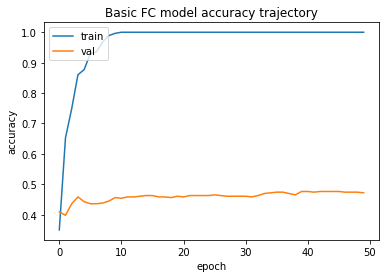

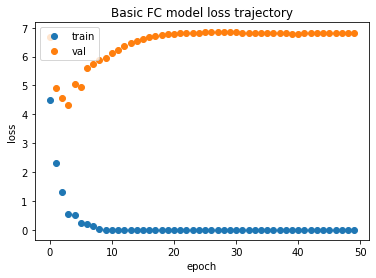

In [14]:
import matplotlib.pyplot as plt

# Plotting accuracy trajectory
plt.plot(basic_fc_model_results.history['accuracy'])
plt.plot(basic_fc_model_results.history['val_accuracy'])
plt.title('Basic FC model accuracy trajectory')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plotting loss trajectory
plt.plot(basic_fc_model_results.history['loss'],'o')
plt.plot(basic_fc_model_results.history['val_loss'],'o')
plt.title('Basic FC model loss trajectory')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [15]:
## Testing the basic FC model

score = basic_fc_model.evaluate(x_test, y_test, verbose=0)
print('Test accuracy of the basic FC model:',score[1])

Test accuracy of the basic FC model: 0.4401806


# CNN Model for subject 0

In [155]:
# Building the CNN model using sequential class
basic_cnn_model = Sequential()

# Conv. block 1
basic_cnn_model.add(Conv2D(filters=25, kernel_size=(10,1), padding='same', activation='elu', input_shape=(1000,1,22)))
basic_cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
basic_cnn_model.add(BatchNormalization())
basic_cnn_model.add(Dropout(0.5))

# Conv. block 2
basic_cnn_model.add(Conv2D(filters=50, kernel_size=(10,1), padding='same', activation='elu'))
basic_cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
basic_cnn_model.add(BatchNormalization())
basic_cnn_model.add(Dropout(0.5))

# Conv. block 3
basic_cnn_model.add(Conv2D(filters=100, kernel_size=(10,1), padding='same', activation='elu'))
basic_cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
basic_cnn_model.add(BatchNormalization())
basic_cnn_model.add(Dropout(0.5))

# Conv. block 4
basic_cnn_model.add(Conv2D(filters=200, kernel_size=(10,1), padding='same', activation='elu'))
basic_cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
basic_cnn_model.add(BatchNormalization())
basic_cnn_model.add(Dropout(0.5))

# Output layer with Softmax activation
basic_cnn_model.add(Flatten()) # Flattens the input
basic_cnn_model.add(Dense(4, activation='softmax')) # Output FC layer with softmax activation


# Printing the model summary
basic_cnn_model.summary()

Model: "sequential_40"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_92 (Conv2D)           (None, 1000, 1, 25)       5525      
_________________________________________________________________
max_pooling2d_92 (MaxPooling (None, 334, 1, 25)        0         
_________________________________________________________________
batch_normalization_101 (Bat (None, 334, 1, 25)        100       
_________________________________________________________________
dropout_130 (Dropout)        (None, 334, 1, 25)        0         
_________________________________________________________________
conv2d_93 (Conv2D)           (None, 334, 1, 50)        12550     
_________________________________________________________________
max_pooling2d_93 (MaxPooling (None, 112, 1, 50)        0         
_________________________________________________________________
batch_normalization_102 (Bat (None, 112, 1, 50)      

In [156]:
# Model parameters
learning_rate = 1e-3
epochs = 100
cnn_optimizer = tf.keras.optimizers.Adam(lr=learning_rate)

In [157]:
# Compiling the model
basic_cnn_model.compile(loss='categorical_crossentropy',
                 optimizer=cnn_optimizer,
                 metrics=['accuracy'])

# Training and validating the model
basic_cnn_model_results = basic_cnn_model.fit(x_train,
             y_train,
             batch_size=64,
             epochs=epochs,
             validation_data=(x_valid, y_valid), verbose=True)

Train on 1668 samples, validate on 447 samples
Epoch 1/100
1668/1668 [==============================] - 5s 3ms/sample - loss: 2.3052 - accuracy: 0.2710 - val_loss: 3.2001 - val_accuracy: 0.2662
Epoch 2/100
1668/1668 [==============================] - 4s 2ms/sample - loss: 2.0913 - accuracy: 0.3165 - val_loss: 1.7890 - val_accuracy: 0.3624
Epoch 3/100
1668/1668 [==============================] - 6s 4ms/sample - loss: 1.9528 - accuracy: 0.3327 - val_loss: 1.6309 - val_accuracy: 0.3468
Epoch 4/100
1668/1668 [==============================] - 4s 3ms/sample - loss: 1.8595 - accuracy: 0.3507 - val_loss: 1.5461 - val_accuracy: 0.3669
Epoch 5/100
1668/1668 [==============================] - 4s 3ms/sample - loss: 1.8100 - accuracy: 0.3597 - val_loss: 1.5399 - val_accuracy: 0.3826
Epoch 6/100
1668/1668 [==============================] - 6s 3ms/sample - loss: 1.6959 - accuracy: 0.3759 - val_loss: 1.5650 - val_accuracy: 0.3647
Epoch 7/100
1668/1668 [==============================] - 4s 3ms/sample 

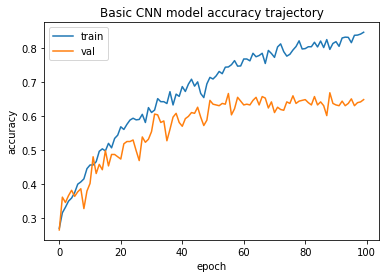

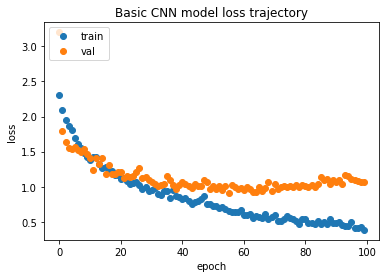

In [158]:
import matplotlib.pyplot as plt

# Plotting accuracy trajectory
plt.plot(basic_cnn_model_results.history['accuracy'])
plt.plot(basic_cnn_model_results.history['val_accuracy'])
plt.title('Basic CNN model accuracy trajectory')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plotting loss trajectory
plt.plot(basic_cnn_model_results.history['loss'],'o')
plt.plot(basic_cnn_model_results.history['val_loss'],'o')
plt.title('Basic CNN model loss trajectory')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [159]:
## Testing the basic CNN model

cnn_score = basic_cnn_model.evaluate(x_test, y_test, verbose=0)
print('Test accuracy of the basic CNN model:',cnn_score[1])

Test accuracy of the basic CNN model: 0.65011287


# CNN Experiments

In [16]:
from tensorflow.keras.callbacks import EarlyStopping

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 1000, 1, 25)       5525      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 334, 1, 25)        0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 334, 1, 25)        100       
_________________________________________________________________
dropout (Dropout)            (None, 334, 1, 25)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 334, 1, 50)        12550     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 112, 1, 50)        0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 112, 1, 50)       

1668/1668 [==============================] - 7s 4ms/sample - loss: 0.9889 - accuracy: 0.5947 - val_loss: 1.2767 - val_accuracy: 0.5235
Epoch 35/100
1668/1668 [==============================] - 7s 4ms/sample - loss: 1.0108 - accuracy: 0.5965 - val_loss: 1.4155 - val_accuracy: 0.5101
Epoch 36/100
1668/1668 [==============================] - 8s 5ms/sample - loss: 0.9780 - accuracy: 0.6199 - val_loss: 1.2645 - val_accuracy: 0.5101
Epoch 37/100
1668/1668 [==============================] - 7s 4ms/sample - loss: 0.9107 - accuracy: 0.6439 - val_loss: 1.1839 - val_accuracy: 0.5414
Epoch 38/100
1668/1668 [==============================] - 7s 4ms/sample - loss: 0.8610 - accuracy: 0.6427 - val_loss: 1.2422 - val_accuracy: 0.5481
Epoch 39/100
1668/1668 [==============================] - 7s 4ms/sample - loss: 0.8367 - accuracy: 0.6673 - val_loss: 1.4071 - val_accuracy: 0.5280
Epoch 40/100
1668/1668 [==============================] - 7s 4ms/sample - loss: 0.8676 - accuracy: 0.6607 - val_loss: 1.2684 

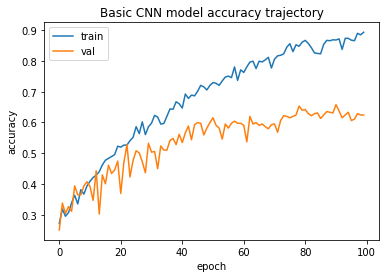

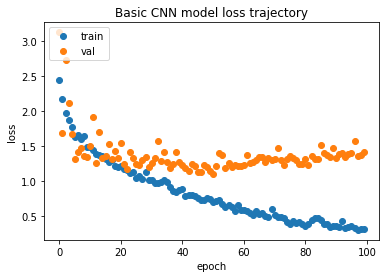

Test accuracy of the basic CNN model: 0.59142214


In [17]:
# Building the CNN model using sequential class
basic_cnn_model = Sequential()

# Conv. block 1
basic_cnn_model.add(Conv2D(filters=25, kernel_size=(10,1), padding='same', activation='elu', input_shape=(1000,1,22)))
basic_cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
basic_cnn_model.add(BatchNormalization())
basic_cnn_model.add(Dropout(0.5))

# Conv. block 2
basic_cnn_model.add(Conv2D(filters=50, kernel_size=(10,1), padding='same', activation='elu'))
basic_cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
basic_cnn_model.add(BatchNormalization())
basic_cnn_model.add(Dropout(0.5))

# Conv. block 3
basic_cnn_model.add(Conv2D(filters=100, kernel_size=(10,1), padding='same', activation='elu'))
basic_cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
basic_cnn_model.add(BatchNormalization())
basic_cnn_model.add(Dropout(0.5))

# Conv. block 4
basic_cnn_model.add(Conv2D(filters=200, kernel_size=(10,1), padding='same', activation='elu'))
basic_cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
basic_cnn_model.add(BatchNormalization())
basic_cnn_model.add(Dropout(0.5))

# Conv. block 5
basic_cnn_model.add(Conv2D(filters=400, kernel_size=(10,1), padding='same', activation='elu'))
basic_cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
basic_cnn_model.add(BatchNormalization())
basic_cnn_model.add(Dropout(0.5))


# Output layer with Softmax activation
basic_cnn_model.add(Flatten()) # Flattens the input
basic_cnn_model.add(Dense(4, activation='softmax')) # Output FC layer with softmax activation


# Printing the model summary
basic_cnn_model.summary()

# Model parameters
learning_rate = 1e-3
epochs = 100
cnn_optimizer = tf.keras.optimizers.Adam(lr=learning_rate)


# Compiling the model
basic_cnn_model.compile(loss='categorical_crossentropy',
                 optimizer=cnn_optimizer,
                 metrics=['accuracy'])

# Stops if val loss does not improve over 15 epochs
# early_stopping = EarlyStopping(monitor='val_loss', patience=15)


# Training and validating the model

basic_cnn_model_results = basic_cnn_model.fit(x_train,
             y_train,
             batch_size=64,
             epochs=epochs,
             validation_data=(x_valid, y_valid), verbose=True)#, callbacks=[early_stopping])


# Plotting accuracy trajectory
plt.plot(basic_cnn_model_results.history['accuracy'])
plt.plot(basic_cnn_model_results.history['val_accuracy'])
plt.title('Basic CNN model accuracy trajectory')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plotting loss trajectory
plt.plot(basic_cnn_model_results.history['loss'],'o')
plt.plot(basic_cnn_model_results.history['val_loss'],'o')
plt.title('Basic CNN model loss trajectory')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


## Testing the basic CNN model

cnn_score = basic_cnn_model.evaluate(x_test, y_test, verbose=0)
print('Test accuracy of the basic CNN model:',cnn_score[1])

# CNN + LSTM Model All data

In [18]:
from tensorflow.keras.optimizers import Adam

In [19]:
rnn_model=Sequential()

# Conv. block 1
rnn_model.add(Conv2D(filters=25, kernel_size=(10,1), padding='same', activation='elu', input_shape=(1000,1,22)))
rnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
rnn_model.add(BatchNormalization())
rnn_model.add(Dropout(0.5))

# Conv. block 2
rnn_model.add(Conv2D(filters=50, kernel_size=(10,1), padding='same', activation='elu'))
rnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
rnn_model.add(BatchNormalization())
rnn_model.add(Dropout(0.5))

# Conv. block 3
rnn_model.add(Conv2D(filters=100, kernel_size=(10,1), padding='same', activation='elu'))
rnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
rnn_model.add(BatchNormalization())
rnn_model.add(Dropout(0.5))

# Conv. block 4
rnn_model.add(Conv2D(filters=200, kernel_size=(10,1), padding='same', activation='elu'))
rnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
rnn_model.add(BatchNormalization())
rnn_model.add(Dropout(0.5))

#rnn_model.add(LSTM(64,input_shape=(1000,22),activation='relu',return_sequences=True))

#rnn_model.add(Dropout(0.2))

#rnn_model.add(LSTM(64,activation='relu', return_sequences=True))

#rnn_model.add(Dropout(0.2))

rnn_model.add(TimeDistributed(LSTM(150,dropout=0.5, recurrent_dropout=0.1,return_sequences=True,activation='elu')))
#rnn_model.add(Dropout(0.5))
rnn_model.add(BatchNormalization())

rnn_model.add(TimeDistributed(LSTM(150,dropout=0.5, recurrent_dropout=0.1,return_sequences=True,activation='elu')))
#rnn_model.add(Dropout(0.5))
rnn_model.add(BatchNormalization())

rnn_model.add(Flatten()) # Flattens the input

rnn_model.add(Dense(4,activation='softmax'))


rnn_optimizer = Adam(lr=1e-2)


rnn_model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

print(rnn_model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 1000, 1, 25)       5525      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 334, 1, 25)        0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 334, 1, 25)        100       
_________________________________________________________________
dropout_5 (Dropout)          (None, 334, 1, 25)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 334, 1, 50)        12550     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 112, 1, 50)        0         
_________________________________________________________________
batch_normalization_9 (Batch (None, 112, 1, 50)       

In [90]:
# Shape of training set after adding width info: (1668, 22, 1000, 1)
# Shape of validation set after adding width info: (447, 22, 1000, 1)
# Shape of test set after adding width info: (443, 22, 1000, 1)

# x_train_rnn = x_train.reshape((1668,1000,22))
# y_train_rnn = y_train

# x_valid_rnn = x_valid.reshape((447,1000,22))
# y_valid_rnn = y_valid

# x_test_rnn = x_test.reshape((443,1000,22))
# y_test_rnn = y_test

In [95]:
basic_rnn_model_results = rnn_model.fit(x_train, y_train,
           batch_size=128,
           epochs=600,
           validation_data=(x_valid, y_valid), verbose=True)

# print(history.history['loss'])
# print(history.history['accuracy'])

Train on 1668 samples, validate on 447 samples
Epoch 1/600
1668/1668 [==============================] - 11s 7ms/sample - loss: 1.9370 - accuracy: 0.2542 - val_loss: 1.3965 - val_accuracy: 0.2931
Epoch 2/600
1668/1668 [==============================] - 5s 3ms/sample - loss: 1.8909 - accuracy: 0.2488 - val_loss: 1.3812 - val_accuracy: 0.2953
Epoch 3/600
1668/1668 [==============================] - 5s 3ms/sample - loss: 1.7551 - accuracy: 0.2668 - val_loss: 1.3762 - val_accuracy: 0.3154
Epoch 4/600
1668/1668 [==============================] - 5s 3ms/sample - loss: 1.7089 - accuracy: 0.2878 - val_loss: 1.3694 - val_accuracy: 0.3512
Epoch 5/600
1668/1668 [==============================] - 5s 3ms/sample - loss: 1.6601 - accuracy: 0.3082 - val_loss: 1.3667 - val_accuracy: 0.3356
Epoch 6/600
1668/1668 [==============================] - 5s 3ms/sample - loss: 1.7035 - accuracy: 0.2818 - val_loss: 1.3705 - val_accuracy: 0.3199
Epoch 7/600
1668/1668 [==============================] - 5s 3ms/sample

1668/1668 [==============================] - 5s 3ms/sample - loss: 1.1215 - accuracy: 0.5174 - val_loss: 1.3089 - val_accuracy: 0.4273
Epoch 112/600
1668/1668 [==============================] - 5s 3ms/sample - loss: 1.0976 - accuracy: 0.5186 - val_loss: 1.2564 - val_accuracy: 0.4430
Epoch 113/600
1668/1668 [==============================] - 5s 3ms/sample - loss: 1.1005 - accuracy: 0.5150 - val_loss: 1.2436 - val_accuracy: 0.4385
Epoch 114/600
1668/1668 [==============================] - 5s 3ms/sample - loss: 1.0958 - accuracy: 0.5360 - val_loss: 1.2722 - val_accuracy: 0.4228
Epoch 115/600
1668/1668 [==============================] - 5s 3ms/sample - loss: 1.0734 - accuracy: 0.5384 - val_loss: 1.2609 - val_accuracy: 0.4139
Epoch 116/600
1668/1668 [==============================] - 5s 3ms/sample - loss: 1.1041 - accuracy: 0.5288 - val_loss: 1.2285 - val_accuracy: 0.4027
Epoch 117/600
1668/1668 [==============================] - 5s 3ms/sample - loss: 1.1142 - accuracy: 0.5138 - val_loss: 1

1668/1668 [==============================] - 5s 3ms/sample - loss: 0.9895 - accuracy: 0.5797 - val_loss: 1.3125 - val_accuracy: 0.4586
Epoch 167/600
1668/1668 [==============================] - 5s 3ms/sample - loss: 0.9356 - accuracy: 0.6151 - val_loss: 1.2450 - val_accuracy: 0.4944
Epoch 168/600
1668/1668 [==============================] - 5s 3ms/sample - loss: 0.9193 - accuracy: 0.6373 - val_loss: 1.3256 - val_accuracy: 0.4586
Epoch 169/600
1668/1668 [==============================] - 5s 3ms/sample - loss: 0.9546 - accuracy: 0.5959 - val_loss: 1.2951 - val_accuracy: 0.4519
Epoch 170/600
1668/1668 [==============================] - 5s 3ms/sample - loss: 0.9505 - accuracy: 0.6259 - val_loss: 1.2584 - val_accuracy: 0.5056
Epoch 171/600
1668/1668 [==============================] - 5s 3ms/sample - loss: 0.9578 - accuracy: 0.6139 - val_loss: 1.3514 - val_accuracy: 0.4474
Epoch 172/600
1668/1668 [==============================] - 5s 3ms/sample - loss: 0.9354 - accuracy: 0.6049 - val_loss: 1

1668/1668 [==============================] - 5s 3ms/sample - loss: 0.7763 - accuracy: 0.6817 - val_loss: 1.1909 - val_accuracy: 0.5391
Epoch 222/600
1668/1668 [==============================] - 5s 3ms/sample - loss: 0.8021 - accuracy: 0.6769 - val_loss: 1.1496 - val_accuracy: 0.5794
Epoch 223/600
1668/1668 [==============================] - 5s 3ms/sample - loss: 0.7697 - accuracy: 0.6882 - val_loss: 1.1631 - val_accuracy: 0.5660
Epoch 224/600
1668/1668 [==============================] - 5s 3ms/sample - loss: 0.7824 - accuracy: 0.6775 - val_loss: 1.1981 - val_accuracy: 0.5615
Epoch 225/600
1668/1668 [==============================] - 5s 3ms/sample - loss: 0.7811 - accuracy: 0.6871 - val_loss: 1.1697 - val_accuracy: 0.5772
Epoch 226/600
1668/1668 [==============================] - 5s 3ms/sample - loss: 0.7419 - accuracy: 0.7008 - val_loss: 1.2017 - val_accuracy: 0.5682
Epoch 227/600
1668/1668 [==============================] - 6s 4ms/sample - loss: 0.7535 - accuracy: 0.6990 - val_loss: 1

1668/1668 [==============================] - 5s 3ms/sample - loss: 0.6703 - accuracy: 0.7320 - val_loss: 1.1335 - val_accuracy: 0.6040
Epoch 277/600
1668/1668 [==============================] - 5s 3ms/sample - loss: 0.6567 - accuracy: 0.7464 - val_loss: 1.1538 - val_accuracy: 0.5861
Epoch 278/600
1668/1668 [==============================] - 5s 3ms/sample - loss: 0.7022 - accuracy: 0.7380 - val_loss: 1.1665 - val_accuracy: 0.5772
Epoch 279/600
1668/1668 [==============================] - 5s 3ms/sample - loss: 0.6802 - accuracy: 0.7332 - val_loss: 1.1676 - val_accuracy: 0.5906
Epoch 280/600
1668/1668 [==============================] - 5s 3ms/sample - loss: 0.7040 - accuracy: 0.7254 - val_loss: 1.1794 - val_accuracy: 0.5861
Epoch 281/600
1668/1668 [==============================] - 5s 3ms/sample - loss: 0.6574 - accuracy: 0.7470 - val_loss: 1.1229 - val_accuracy: 0.6085
Epoch 282/600
1668/1668 [==============================] - 5s 3ms/sample - loss: 0.6867 - accuracy: 0.7236 - val_loss: 1

1668/1668 [==============================] - 5s 3ms/sample - loss: 0.5584 - accuracy: 0.7860 - val_loss: 1.1877 - val_accuracy: 0.6040
Epoch 332/600
1668/1668 [==============================] - 5s 3ms/sample - loss: 0.5243 - accuracy: 0.7992 - val_loss: 1.2092 - val_accuracy: 0.6107
Epoch 333/600
1668/1668 [==============================] - 5s 3ms/sample - loss: 0.5756 - accuracy: 0.7794 - val_loss: 1.2436 - val_accuracy: 0.6130
Epoch 334/600
1668/1668 [==============================] - 5s 3ms/sample - loss: 0.6015 - accuracy: 0.7674 - val_loss: 1.1870 - val_accuracy: 0.5928
Epoch 335/600
1668/1668 [==============================] - 5s 3ms/sample - loss: 0.6020 - accuracy: 0.7680 - val_loss: 1.2461 - val_accuracy: 0.5861
Epoch 336/600
1668/1668 [==============================] - 5s 3ms/sample - loss: 0.5950 - accuracy: 0.7758 - val_loss: 1.2064 - val_accuracy: 0.5951
Epoch 337/600
1668/1668 [==============================] - 5s 3ms/sample - loss: 0.5715 - accuracy: 0.7878 - val_loss: 1

1668/1668 [==============================] - 5s 3ms/sample - loss: 0.4714 - accuracy: 0.8243 - val_loss: 1.1404 - val_accuracy: 0.6443
Epoch 387/600
1668/1668 [==============================] - 5s 3ms/sample - loss: 0.5112 - accuracy: 0.8076 - val_loss: 1.1318 - val_accuracy: 0.6622
Epoch 388/600
1668/1668 [==============================] - 5s 3ms/sample - loss: 0.4953 - accuracy: 0.8135 - val_loss: 1.1391 - val_accuracy: 0.6242
Epoch 389/600
1668/1668 [==============================] - 5s 3ms/sample - loss: 0.5138 - accuracy: 0.8106 - val_loss: 1.2591 - val_accuracy: 0.6018
Epoch 390/600
1668/1668 [==============================] - 5s 3ms/sample - loss: 0.5124 - accuracy: 0.8010 - val_loss: 1.2002 - val_accuracy: 0.6197
Epoch 391/600
1668/1668 [==============================] - 5s 3ms/sample - loss: 0.4910 - accuracy: 0.8076 - val_loss: 1.2177 - val_accuracy: 0.5996
Epoch 392/600
1668/1668 [==============================] - 5s 3ms/sample - loss: 0.4619 - accuracy: 0.8273 - val_loss: 1

1668/1668 [==============================] - 5s 3ms/sample - loss: 0.4006 - accuracy: 0.8537 - val_loss: 1.1508 - val_accuracy: 0.6421
Epoch 442/600
1668/1668 [==============================] - 5s 3ms/sample - loss: 0.3922 - accuracy: 0.8513 - val_loss: 1.1559 - val_accuracy: 0.6510
Epoch 443/600
1668/1668 [==============================] - 5s 3ms/sample - loss: 0.4065 - accuracy: 0.8339 - val_loss: 1.1668 - val_accuracy: 0.6532
Epoch 444/600
1668/1668 [==============================] - 5s 3ms/sample - loss: 0.4298 - accuracy: 0.8273 - val_loss: 1.1834 - val_accuracy: 0.6421
Epoch 445/600
1668/1668 [==============================] - 5s 3ms/sample - loss: 0.4243 - accuracy: 0.8393 - val_loss: 1.1579 - val_accuracy: 0.6443
Epoch 446/600
1668/1668 [==============================] - 5s 3ms/sample - loss: 0.3955 - accuracy: 0.8471 - val_loss: 1.1479 - val_accuracy: 0.6421
Epoch 447/600
1668/1668 [==============================] - 5s 3ms/sample - loss: 0.4441 - accuracy: 0.8357 - val_loss: 1

1668/1668 [==============================] - 5s 3ms/sample - loss: 0.3950 - accuracy: 0.8405 - val_loss: 1.2907 - val_accuracy: 0.6353
Epoch 497/600
1668/1668 [==============================] - 5s 3ms/sample - loss: 0.3809 - accuracy: 0.8549 - val_loss: 1.2930 - val_accuracy: 0.6152
Epoch 498/600
1668/1668 [==============================] - 5s 3ms/sample - loss: 0.3472 - accuracy: 0.8759 - val_loss: 1.2684 - val_accuracy: 0.6331
Epoch 499/600
1668/1668 [==============================] - 5s 3ms/sample - loss: 0.3511 - accuracy: 0.8573 - val_loss: 1.2380 - val_accuracy: 0.6398
Epoch 500/600
1668/1668 [==============================] - 5s 3ms/sample - loss: 0.3736 - accuracy: 0.8591 - val_loss: 1.2304 - val_accuracy: 0.6376
Epoch 501/600
1668/1668 [==============================] - 5s 3ms/sample - loss: 0.3888 - accuracy: 0.8483 - val_loss: 1.2290 - val_accuracy: 0.6309
Epoch 502/600
1668/1668 [==============================] - 5s 3ms/sample - loss: 0.3607 - accuracy: 0.8603 - val_loss: 1

1668/1668 [==============================] - 5s 3ms/sample - loss: 0.3124 - accuracy: 0.8813 - val_loss: 1.2590 - val_accuracy: 0.6398
Epoch 552/600
1668/1668 [==============================] - 5s 3ms/sample - loss: 0.3666 - accuracy: 0.8633 - val_loss: 1.2483 - val_accuracy: 0.6286
Epoch 553/600
1668/1668 [==============================] - 5s 3ms/sample - loss: 0.3517 - accuracy: 0.8633 - val_loss: 1.2696 - val_accuracy: 0.6421
Epoch 554/600
1668/1668 [==============================] - 5s 3ms/sample - loss: 0.3591 - accuracy: 0.8627 - val_loss: 1.2181 - val_accuracy: 0.6242
Epoch 555/600
1668/1668 [==============================] - 5s 3ms/sample - loss: 0.3683 - accuracy: 0.8633 - val_loss: 1.3076 - val_accuracy: 0.6242
Epoch 556/600
1668/1668 [==============================] - 5s 3ms/sample - loss: 0.3712 - accuracy: 0.8531 - val_loss: 1.2522 - val_accuracy: 0.6309
Epoch 557/600
1668/1668 [==============================] - 5s 3ms/sample - loss: 0.3726 - accuracy: 0.8507 - val_loss: 1

In [1]:
import matplotlib.pyplot as plt

# Plotting accuracy trajectory
plt.plot(basic_rnn_model_results.history['accuracy'])
plt.plot(basic_rnn_model_results.history['val_accuracy'])
plt.title('Basic RNN model accuracy trajectory')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plotting loss trajectory
plt.plot(basic_rnn_model_results.history['loss'],'o')
plt.plot(basic_rnn_model_results.history['val_loss'],'o')
plt.title('Basic CNN model loss trajectory')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

NameError: name 'basic_rnn_model_results' is not defined

In [93]:
## Testing the basic RNN model

rnn_score = rnn_model.evaluate(x_test, y_test, verbose=0)
print('Test accuracy of the basic CNN model:',rnn_score[1])

Test accuracy of the basic CNN model: 0.489842


# RNN/ GRU Experiment

In [47]:
gru_model = Sequential()
#1
gru_model.add(GRU(50, return_sequences=True, stateful=False,
         recurrent_dropout=0.6, dropout = 0.5, input_shape=(1000,22)))

#2
gru_model.add(GRU(25, return_sequences=True, stateful=False,
          recurrent_dropout=0.6, dropout = 0.5))

#3
gru_model.add(GRU(25, return_sequences=True, stateful=False,
          recurrent_dropout=0.6, dropout = 0.5))
gru_model.add(Flatten())

#4
gru_model.add(Dense(20))
gru_model.add(BatchNormalization(axis=-1))
gru_model.add(Activation('relu'))
gru_model.add(Dropout(0.5))

#5
gru_model.add(Dense(4, activation='softmax'))

gru_model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

#rnn_model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

print(gru_model.summary())

# define early stopping callback
#earlystop = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=70, mode='auto')


#callbacks_list = [earlystop]


Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_40 (GRU)                 (None, 1000, 50)          11100     
_________________________________________________________________
gru_41 (GRU)                 (None, 1000, 25)          5775      
_________________________________________________________________
gru_42 (GRU)                 (None, 1000, 25)          3900      
_________________________________________________________________
flatten_13 (Flatten)         (None, 25000)             0         
_________________________________________________________________
dense_31 (Dense)             (None, 20)                500020    
_________________________________________________________________
batch_normalization_27 (Batc (None, 20)                80        
_________________________________________________________________
activation_13 (Activation)   (None, 20)              

In [48]:
x_train_gru = x_train.reshape((1668,1000,22))
y_train_gru = y_train

x_valid_gru = x_valid.reshape((447,1000,22))
y_valid_gru = y_valid

x_test_gru = x_test.reshape((443,1000,22))
y_test_gru = y_test

In [49]:
history = gru_model.fit(x_train_gru, y_train_gru,
                    batch_size=128, epochs=50, shuffle=True,
                    validation_data=(x_valid_gru, y_valid_gru))#, callbacks=callbacks_list)


Train on 1668 samples, validate on 447 samples
Epoch 1/50
1668/1668 [==============================] - 102s 61ms/sample - loss: 1.7512 - accuracy: 0.2566 - val_loss: 1.5522 - val_accuracy: 0.2886
Epoch 2/50
1668/1668 [==============================] - 98s 59ms/sample - loss: 1.6106 - accuracy: 0.2740 - val_loss: 1.4770 - val_accuracy: 0.2975
Epoch 3/50
1668/1668 [==============================] - 98s 59ms/sample - loss: 1.5994 - accuracy: 0.2824 - val_loss: 1.4612 - val_accuracy: 0.2908
Epoch 4/50
1668/1668 [==============================] - 101s 60ms/sample - loss: 1.5477 - accuracy: 0.2866 - val_loss: 1.3547 - val_accuracy: 0.3557
Epoch 5/50
1668/1668 [==============================] - 102s 61ms/sample - loss: 1.5419 - accuracy: 0.2824 - val_loss: 1.3593 - val_accuracy: 0.3311
Epoch 6/50
1668/1668 [==============================] - 101s 61ms/sample - loss: 1.5385 - accuracy: 0.2830 - val_loss: 1.3739 - val_accuracy: 0.3289
Epoch 7/50
1668/1668 [==============================] - 100s 

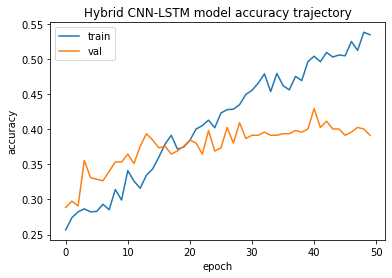

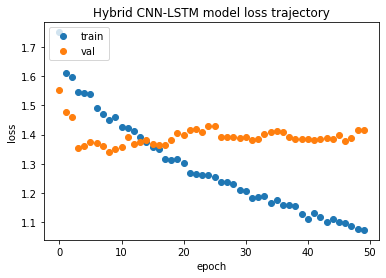

In [50]:
import matplotlib.pyplot as plt

# Plotting accuracy trajectory
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Hybrid CNN-LSTM model accuracy trajectory')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plotting loss trajectory
plt.plot(history.history['loss'],'o')
plt.plot(history.history['val_loss'],'o')
plt.title('Hybrid CNN-LSTM model loss trajectory')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [51]:
## Testing the hybrid CNN-LSTM model

gru_score = gru_model.evaluate(x_test_gru, y_test_gru, verbose=0)
print('Test accuracy of the hybrid CNN-LSTM model:',gru_score[1])

Test accuracy of the hybrid CNN-LSTM model: 0.35214448


# Function of Time

In [130]:
def cnn_model(time_period=1000):   
    basic_cnn_model = Sequential()

    # Conv. block 1
    basic_cnn_model.add(Conv2D(filters=100, kernel_size=(10,1), padding='same', activation='elu', input_shape=(time_period,1,22)))
    basic_cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
    basic_cnn_model.add(BatchNormalization())
    basic_cnn_model.add(Dropout(0.5))

    # Conv. block 2
    basic_cnn_model.add(Conv2D(filters=100, kernel_size=(10,1), padding='same', activation='elu'))
    basic_cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
    basic_cnn_model.add(BatchNormalization())
    basic_cnn_model.add(Dropout(0.5))

    # Conv. block 3
    basic_cnn_model.add(Conv2D(filters=100, kernel_size=(10,1), padding='same', activation='elu'))
    basic_cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
    basic_cnn_model.add(BatchNormalization())
    basic_cnn_model.add(Dropout(0.5))

    # Conv. block 4
    basic_cnn_model.add(Conv2D(filters=100, kernel_size=(10,1), padding='same', activation='elu'))
    basic_cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
    basic_cnn_model.add(BatchNormalization())
    basic_cnn_model.add(Dropout(0.5))

    # Output layer with Softmax activation
    basic_cnn_model.add(Flatten()) # Flattens the input
    basic_cnn_model.add(Dense(4, activation='softmax')) # Output FC layer with softmax activation


    # Printing the model summary
    basic_cnn_model.summary()

    # Compiling the model
    basic_cnn_model.compile(loss='categorical_crossentropy',
                 optimizer='adam',
                 metrics=['accuracy'])
    
    return basic_cnn_model

In [131]:
def train_data(time_period=1000):
    # different period of time
    x_train_time = x_train[:,:time_period,:,:]
    y_train_time = y_train
    x_valid_time = x_valid[:,:time_period,:,:]
    y_valid_time = y_valid
    x_test_time = x_test[:,:time_period,:,:]
    y_test_time = y_test

#     # preprocess data
#     X_train_valid_cur = np.expand_dims(X_train_valid_cur, axis=3)
#     X_test_cur = np.expand_dims(X_test_cur, axis=3)
    
    #lecun = lecun_uniform(seed=42)
    
    
    model = cnn_model(time_period)
    
    model.fit(x_train_time, y_train_time, epochs=50, batch_size=64, validation_data=(x_valid_time, y_valid_time), shuffle=True, verbose=1)
    
    train_score = model.evaluate(x_train_time, y_train_time)
    
    test_score = model.evaluate(x_test_time, y_test_time)

    print('train {:s}: {:.3f}%'.format(model.metrics_names[1], train_score[1]*100))
    print('test {:s}: {:.3f}%'.format(model.metrics_names[1], test_score[1]*100))
    #print(model.summary())
    
    return train_score, test_score

In [32]:
train_score, test_score = train_data(1000)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 1000, 1, 25)       5525      
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 334, 1, 25)        0         
_________________________________________________________________
batch_normalization_24 (Batc (None, 334, 1, 25)        100       
_________________________________________________________________
dropout_24 (Dropout)         (None, 334, 1, 25)        0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 334, 1, 50)        12550     
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 112, 1, 50)        0         
_________________________________________________________________
batch_normalization_25 (Batc (None, 112, 1, 50)       

Epoch 38/50
1668/1668 [==============================] - 4s 2ms/sample - loss: 0.8794 - accuracy: 0.6619 - val_loss: 1.0548 - val_accuracy: 0.5526
Epoch 39/50
1668/1668 [==============================] - 4s 2ms/sample - loss: 0.8485 - accuracy: 0.6715 - val_loss: 1.1397 - val_accuracy: 0.5235
Epoch 40/50
1668/1668 [==============================] - 4s 2ms/sample - loss: 0.8507 - accuracy: 0.6637 - val_loss: 1.2735 - val_accuracy: 0.5168
Epoch 41/50
1668/1668 [==============================] - 4s 2ms/sample - loss: 0.8580 - accuracy: 0.6613 - val_loss: 1.0906 - val_accuracy: 0.5794
Epoch 42/50
1668/1668 [==============================] - 4s 2ms/sample - loss: 0.8519 - accuracy: 0.6523 - val_loss: 1.0629 - val_accuracy: 0.5548
Epoch 43/50
1668/1668 [==============================] - 4s 2ms/sample - loss: 0.8570 - accuracy: 0.6763 - val_loss: 1.0569 - val_accuracy: 0.5727
Epoch 44/50
1668/1668 [==============================] - 4s 2ms/sample - loss: 0.8088 - accuracy: 0.6721 - val_loss: 1

=================100===================
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_28 (Conv2D)           (None, 100, 1, 25)        5525      
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 34, 1, 25)         0         
_________________________________________________________________
batch_normalization_28 (Batc (None, 34, 1, 25)         100       
_________________________________________________________________
dropout_28 (Dropout)         (None, 34, 1, 25)         0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 34, 1, 50)         12550     
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 12, 1, 50)         0         
_________________________________________________________________
batch_normaliz

1668/1668 [==============================] - 1s 877us/sample - loss: 1.9816 - accuracy: 0.3195 - val_loss: 1.7836 - val_accuracy: 0.2707
Epoch 4/50
1668/1668 [==============================] - 1s 831us/sample - loss: 1.8367 - accuracy: 0.3315 - val_loss: 1.6528 - val_accuracy: 0.3289
Epoch 5/50
1668/1668 [==============================] - 1s 836us/sample - loss: 1.8102 - accuracy: 0.3297 - val_loss: 1.4941 - val_accuracy: 0.3378
Epoch 6/50
1668/1668 [==============================] - 2s 1ms/sample - loss: 1.7047 - accuracy: 0.3555 - val_loss: 1.2982 - val_accuracy: 0.4027
Epoch 7/50
1668/1668 [==============================] - 1s 808us/sample - loss: 1.6063 - accuracy: 0.3519 - val_loss: 1.3509 - val_accuracy: 0.3714
Epoch 8/50
1668/1668 [==============================] - 1s 831us/sample - loss: 1.6042 - accuracy: 0.3441 - val_loss: 1.3363 - val_accuracy: 0.3624
Epoch 9/50
1668/1668 [==============================] - 1s 822us/sample - loss: 1.4613 - accuracy: 0.3885 - val_loss: 1.3114 

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_36 (Conv2D)           (None, 500, 1, 25)        5525      
_________________________________________________________________
max_pooling2d_36 (MaxPooling (None, 167, 1, 25)        0         
_________________________________________________________________
batch_normalization_36 (Batc (None, 167, 1, 25)        100       
_________________________________________________________________
dropout_36 (Dropout)         (None, 167, 1, 25)        0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 167, 1, 50)        12550     
_________________________________________________________________
max_pooling2d_37 (MaxPooling (None, 56, 1, 50)         0         
_________________________________________________________________
batch_normalization_37 (Batc (None, 56, 1, 50)        

Epoch 38/50
1668/1668 [==============================] - 2s 1ms/sample - loss: 0.9054 - accuracy: 0.6259 - val_loss: 1.0103 - val_accuracy: 0.5884
Epoch 39/50
1668/1668 [==============================] - 2s 1ms/sample - loss: 0.9061 - accuracy: 0.6337 - val_loss: 0.9406 - val_accuracy: 0.5839
Epoch 40/50
1668/1668 [==============================] - 2s 1ms/sample - loss: 0.8880 - accuracy: 0.6307 - val_loss: 1.0223 - val_accuracy: 0.5548
Epoch 41/50
1668/1668 [==============================] - 3s 2ms/sample - loss: 0.8846 - accuracy: 0.6529 - val_loss: 0.9732 - val_accuracy: 0.5817
Epoch 42/50
1668/1668 [==============================] - 2s 1ms/sample - loss: 0.8928 - accuracy: 0.6361 - val_loss: 0.9329 - val_accuracy: 0.5861
Epoch 43/50
1668/1668 [==============================] - 2s 1ms/sample - loss: 0.8936 - accuracy: 0.6379 - val_loss: 0.9553 - val_accuracy: 0.5817
Epoch 44/50
1668/1668 [==============================] - 2s 1ms/sample - loss: 0.9270 - accuracy: 0.6151 - val_loss: 0

_________________________________________________________________
dropout_41 (Dropout)         (None, 78, 1, 50)         0         
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 78, 1, 100)        50100     
_________________________________________________________________
max_pooling2d_42 (MaxPooling (None, 26, 1, 100)        0         
_________________________________________________________________
batch_normalization_42 (Batc (None, 26, 1, 100)        400       
_________________________________________________________________
dropout_42 (Dropout)         (None, 26, 1, 100)        0         
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 26, 1, 200)        200200    
_________________________________________________________________
max_pooling2d_43 (MaxPooling (None, 9, 1, 200)         0         
_________________________________________________________________
batch_norm

ValueError: x and y must have same first dimension, but have shapes (19,) and (5,)

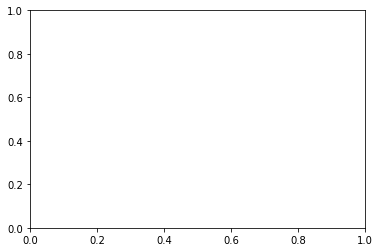

In [33]:
train_scores = []
test_scores = []

for time in range(100, 1001, 200):
    print("=================" + str(time) + "===================")
    train_score, test_score = train_data(time_period=time)
    train_scores.append(train_score[1])
    test_scores.append(test_score[1])


Train accuracies: 
[0.54976016, 0.7320144, 0.8189449, 0.8201439, 0.83693045]
Test accuracies: 
[0.4717833, 0.58239275, 0.62528217, 0.6230248, 0.6275395]


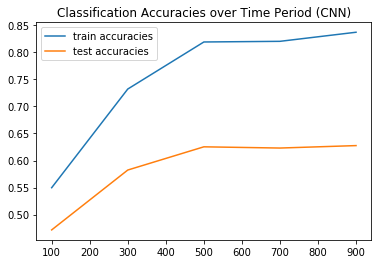

In [45]:
print("Train accuracies: ")
print(train_scores)
print("Test accuracies: ")
print(test_scores)

# plot
plt.plot(range(100, 1001, 200), train_scores, label='train accuracies')
plt.plot(range(100, 1001, 200), test_scores, label='test accuracies')
plt.legend()
plt.title("Classification Accuracies over Time Period (CNN)")
plt.show()

# Optimized CNN models

In [134]:
X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")
person_train_valid = np.load("person_train_valid.npy")
X_train_valid = np.load("X_train_valid.npy")
y_train_valid = np.load("y_train_valid.npy")
person_test = np.load("person_test.npy")

## Printing the shapes of the numpy arrays

print ('Training/Valid data shape: {}'.format(X_train_valid.shape))
print ('Test data shape: {}'.format(X_test.shape))
print ('Training/Valid target shape: {}'.format(y_train_valid.shape))
print ('Test target shape: {}'.format(y_test.shape))
print ('Person train/valid shape: {}'.format(person_train_valid.shape))
print ('Person test shape: {}'.format(person_test.shape))


Training/Valid data shape: (2115, 22, 1000)
Test data shape: (443, 22, 1000)
Training/Valid target shape: (2115,)
Test target shape: (443,)
Person train/valid shape: (2115, 1)
Person test shape: (443, 1)


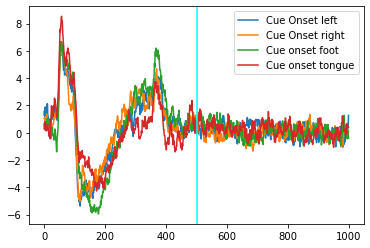

In [135]:
## Adjusting the labels to {0,1,2,3}

# Cue onset left - 0
# Cue onset right - 1
# Cue onset foot - 2
# Cue onset tongue - 3

y_train_valid -= 769
y_test -= 769
## Visualizing the data

ch_data = X_train_valid[:,8,:]


class_0_ind = np.where(y_train_valid == 0)
ch_data_class_0 = ch_data[class_0_ind]
avg_ch_data_class_0 = np.mean(ch_data_class_0,axis=0)


class_1_ind = np.where(y_train_valid == 1)
ch_data_class_1 = ch_data[class_1_ind]
avg_ch_data_class_1 = np.mean(ch_data_class_1,axis=0)

class_2_ind = np.where(y_train_valid == 2)
ch_data_class_2 = ch_data[class_2_ind]
avg_ch_data_class_2 = np.mean(ch_data_class_2,axis=0)

class_3_ind = np.where(y_train_valid == 3)
ch_data_class_3 = ch_data[class_3_ind]
avg_ch_data_class_3 = np.mean(ch_data_class_3,axis=0)


plt.plot(np.arange(1000),avg_ch_data_class_0)
plt.plot(np.arange(1000),avg_ch_data_class_1)
plt.plot(np.arange(1000),avg_ch_data_class_2)
plt.plot(np.arange(1000),avg_ch_data_class_3)
plt.axvline(x=500, label='line at t=500',c='cyan')

plt.legend(["Cue Onset left", "Cue Onset right", "Cue onset foot", "Cue onset tongue"])


In [136]:
def data_prep(X,y,sub_sample,average,noise):
    
    total_X = None
    total_y = None
    
    # Trimming the data (sample,22,1000) -> (sample,22,500)
    X = X[:,:,0:500]
    print('Shape of X after trimming:',X.shape)
    
    # Maxpooling the data (sample,22,1000) -> (sample,22,500/sub_sample)
    X_max = np.max(X.reshape(X.shape[0], X.shape[1], -1, sub_sample), axis=3)
    
    
    total_X = X_max
    total_y = y
    print('Shape of X after maxpooling:',total_X.shape)
    
    # Averaging + noise 
    X_average = np.mean(X.reshape(X.shape[0], X.shape[1], -1, average),axis=3)
    X_average = X_average + np.random.normal(0.0, 0.5, X_average.shape)
    
    total_X = np.vstack((total_X, X_average))
    total_y = np.hstack((total_y, y))
    print('Shape of X after averaging+noise and concatenating:',total_X.shape)
    
    # Subsampling
    
    for i in range(sub_sample):
        
        X_subsample = X[:, :, i::sub_sample] + \
                            (np.random.normal(0.0, 0.5, X[:, :,i::sub_sample].shape) if noise else 0.0)
            
        total_X = np.vstack((total_X, X_subsample))
        total_y = np.hstack((total_y, y))
        
    
    print('Shape of X after subsampling and concatenating:',total_X.shape)
    return total_X,total_y


X_train_valid_prep,y_train_valid_prep = data_prep(X_train_valid,y_train_valid,2,2,True)


Shape of X after trimming: (2115, 22, 500)
Shape of X after maxpooling: (2115, 22, 250)
Shape of X after averaging+noise and concatenating: (4230, 22, 250)
Shape of X after subsampling and concatenating: (8460, 22, 250)


In [137]:
## Preprocessing the dataset

X_train_valid_prep,y_train_valid_prep = data_prep(X_train_valid,y_train_valid,2,2,True)
X_test_prep,y_test_prep = data_prep(X_test,y_test,2,2,True)

print(X_train_valid_prep.shape)
print(y_train_valid_prep.shape)
print(X_test_prep.shape)
print(y_test_prep.shape)



## Random splitting and reshaping the data

# First generating the training and validation indices using random splitting
ind_valid = np.random.choice(8460, 1500, replace=False)
ind_train = np.array(list(set(range(8460)).difference(set(ind_valid))))

# Creating the training and validation sets using the generated indices
(x_train, x_valid) = X_train_valid_prep[ind_train], X_train_valid_prep[ind_valid] 
(y_train, y_valid) = y_train_valid_prep[ind_train], y_train_valid_prep[ind_valid]
print('Shape of training set:',x_train.shape)
print('Shape of validation set:',x_valid.shape)
print('Shape of training labels:',y_train.shape)
print('Shape of validation labels:',y_valid.shape)


# Converting the labels to categorical variables for multiclass classification
y_train = to_categorical(y_train, 4)
y_valid = to_categorical(y_valid, 4)
y_test = to_categorical(y_test_prep, 4)
print('Shape of training labels after categorical conversion:',y_train.shape)
print('Shape of validation labels after categorical conversion:',y_valid.shape)
print('Shape of test labels after categorical conversion:',y_test.shape)

# Adding width of the segment to be 1
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_valid = x_valid.reshape(x_valid.shape[0], x_valid.shape[1], x_train.shape[2], 1)
x_test = X_test_prep.reshape(X_test_prep.shape[0], X_test_prep.shape[1], X_test_prep.shape[2], 1)
print('Shape of training set after adding width info:',x_train.shape)
print('Shape of validation set after adding width info:',x_valid.shape)
print('Shape of test set after adding width info:',x_test.shape)


# Reshaping the training and validation dataset
x_train = np.swapaxes(x_train, 1,3)
x_train = np.swapaxes(x_train, 1,2)
x_valid = np.swapaxes(x_valid, 1,3)
x_valid = np.swapaxes(x_valid, 1,2)
x_test = np.swapaxes(x_test, 1,3)
x_test = np.swapaxes(x_test, 1,2)
print('Shape of training set after dimension reshaping:',x_train.shape)
print('Shape of validation set after dimension reshaping:',x_valid.shape)
print('Shape of test set after dimension reshaping:',x_test.shape)


Shape of X after trimming: (2115, 22, 500)
Shape of X after maxpooling: (2115, 22, 250)
Shape of X after averaging+noise and concatenating: (4230, 22, 250)
Shape of X after subsampling and concatenating: (8460, 22, 250)
Shape of X after trimming: (443, 22, 500)
Shape of X after maxpooling: (443, 22, 250)
Shape of X after averaging+noise and concatenating: (886, 22, 250)
Shape of X after subsampling and concatenating: (1772, 22, 250)
(8460, 22, 250)
(8460,)
(1772, 22, 250)
(1772,)
Shape of training set: (6960, 22, 250)
Shape of validation set: (1500, 22, 250)
Shape of training labels: (6960,)
Shape of validation labels: (1500,)
Shape of training labels after categorical conversion: (6960, 4)
Shape of validation labels after categorical conversion: (1500, 4)
Shape of test labels after categorical conversion: (1772, 4)
Shape of training set after adding width info: (6960, 22, 250, 1)
Shape of validation set after adding width info: (1500, 22, 250, 1)
Shape of test set after adding width i

In [108]:
# Building the CNN model using sequential class
basic_cnn_model = Sequential()

# Conv. block 1
basic_cnn_model.add(Conv2D(filters=25, kernel_size=(10,1), padding='same', activation='elu', input_shape=(250,1,22)))
basic_cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same')) # Read the keras documentation
basic_cnn_model.add(BatchNormalization())
basic_cnn_model.add(Dropout(0.5))

# Conv. block 2
basic_cnn_model.add(Conv2D(filters=50, kernel_size=(10,1), padding='same', activation='elu'))
basic_cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
basic_cnn_model.add(BatchNormalization())
basic_cnn_model.add(Dropout(0.5))

# Conv. block 3
basic_cnn_model.add(Conv2D(filters=100, kernel_size=(10,1), padding='same', activation='elu'))
basic_cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
basic_cnn_model.add(BatchNormalization())
basic_cnn_model.add(Dropout(0.5))

# # Conv. block 4
# basic_cnn_model.add(Conv2D(filters=100, kernel_size=(10,1), padding='same', activation='elu'))
# basic_cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
# basic_cnn_model.add(BatchNormalization())
# basic_cnn_model.add(Dropout(0.5))

# Output layer with Softmax activation
basic_cnn_model.add(Flatten()) # Flattens the input
basic_cnn_model.add(Dense(4, activation='softmax')) # Output FC layer with softmax activation


# Printing the model summary
basic_cnn_model.summary()

Model: "sequential_63"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_249 (Conv2D)          (None, 250, 1, 25)        5525      
_________________________________________________________________
max_pooling2d_249 (MaxPoolin (None, 84, 1, 25)         0         
_________________________________________________________________
batch_normalization_249 (Bat (None, 84, 1, 25)         100       
_________________________________________________________________
dropout_249 (Dropout)        (None, 84, 1, 25)         0         
_________________________________________________________________
conv2d_250 (Conv2D)          (None, 84, 1, 50)         12550     
_________________________________________________________________
max_pooling2d_250 (MaxPoolin (None, 28, 1, 50)         0         
_________________________________________________________________
batch_normalization_250 (Bat (None, 28, 1, 50)       

In [109]:
# Model parameters
learning_rate = 1.5e-4
epochs = 200
cnn_optimizer = optimizers.Adam(learning_rate)

In [110]:
# Compiling the model
basic_cnn_model.compile(loss='categorical_crossentropy',
                 optimizer=cnn_optimizer,
                 metrics=['accuracy'])

# Training and validating the model
basic_cnn_model_results = basic_cnn_model.fit(x_train,
             y_train,
             batch_size=200,
             epochs=epochs,
             validation_data=(x_valid, y_valid), verbose=True)

Train on 6960 samples, validate on 1500 samples
Epoch 1/200
6960/6960 [==============================] - 8s 1ms/sample - loss: 2.1866 - acc: 0.2790 - val_loss: 1.9333 - val_acc: 0.3187
Epoch 2/200
6960/6960 [==============================] - 1s 183us/sample - loss: 2.0443 - acc: 0.3116 - val_loss: 1.4743 - val_acc: 0.3680
Epoch 3/200
6960/6960 [==============================] - 1s 176us/sample - loss: 1.9366 - acc: 0.3267 - val_loss: 1.3857 - val_acc: 0.3760
Epoch 4/200
6960/6960 [==============================] - 1s 178us/sample - loss: 1.8918 - acc: 0.3333 - val_loss: 1.2833 - val_acc: 0.4227
Epoch 5/200
6960/6960 [==============================] - 1s 181us/sample - loss: 1.8352 - acc: 0.3319 - val_loss: 1.2447 - val_acc: 0.4307
Epoch 6/200
6960/6960 [==============================] - 1s 177us/sample - loss: 1.7522 - acc: 0.3562 - val_loss: 1.2196 - val_acc: 0.4547
Epoch 7/200
6960/6960 [==============================] - 1s 181us/sample - loss: 1.7327 - acc: 0.3575 - val_loss: 1.1895

6960/6960 [==============================] - 1s 184us/sample - loss: 0.6133 - acc: 0.7651 - val_loss: 0.5266 - val_acc: 0.7973
Epoch 118/200
6960/6960 [==============================] - 1s 183us/sample - loss: 0.6158 - acc: 0.7606 - val_loss: 0.5196 - val_acc: 0.8027
Epoch 119/200
6960/6960 [==============================] - 1s 185us/sample - loss: 0.6252 - acc: 0.7609 - val_loss: 0.5210 - val_acc: 0.8013
Epoch 120/200
6960/6960 [==============================] - 1s 187us/sample - loss: 0.6125 - acc: 0.7654 - val_loss: 0.5103 - val_acc: 0.8073
Epoch 121/200
6960/6960 [==============================] - 1s 189us/sample - loss: 0.6100 - acc: 0.7598 - val_loss: 0.5011 - val_acc: 0.8113
Epoch 122/200
6960/6960 [==============================] - 1s 194us/sample - loss: 0.6115 - acc: 0.7678 - val_loss: 0.5105 - val_acc: 0.8060
Epoch 123/200
6960/6960 [==============================] - 1s 197us/sample - loss: 0.6071 - acc: 0.7609 - val_loss: 0.5062 - val_acc: 0.8087
Epoch 124/200
6960/6960 [==

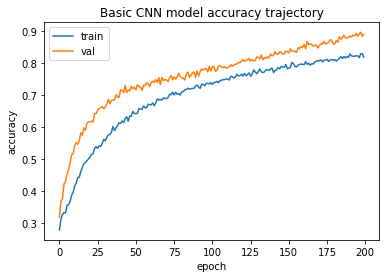

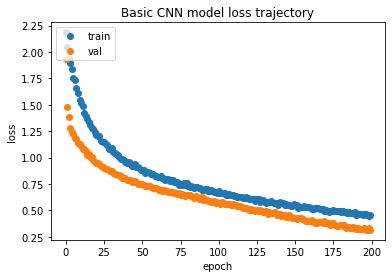

In [111]:
import matplotlib.pyplot as plt

# Plotting accuracy trajectory
plt.plot(basic_cnn_model_results.history['acc'])
plt.plot(basic_cnn_model_results.history['val_acc'])
plt.title('Basic CNN model accuracy trajectory')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plotting loss trajectory
plt.plot(basic_cnn_model_results.history['loss'],'o')
plt.plot(basic_cnn_model_results.history['val_loss'],'o')
plt.title('Basic CNN model loss trajectory')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [112]:
## Testing the basic CNN model

cnn_score = basic_cnn_model.evaluate(x_test, y_test, verbose=0)
print('Test accuracy of the basic CNN model:',cnn_score[1])

Test accuracy of the basic CNN model: 0.73419863


# Optimized CNN+LSTM models

In [149]:
# Building the CNN model using sequential class
hybrid_cnn_lstm_model = Sequential()

# Conv. block 1
hybrid_cnn_lstm_model.add(Conv2D(filters=100, kernel_size=(10,1), padding='same', activation='elu', input_shape=(250,1,22)))
hybrid_cnn_lstm_model.add(MaxPooling2D(pool_size=(3,1), padding='same')) # Read the keras documentation
hybrid_cnn_lstm_model.add(BatchNormalization())
hybrid_cnn_lstm_model.add(Dropout(0.5))

# Conv. block 2
hybrid_cnn_lstm_model.add(Conv2D(filters=100, kernel_size=(10,1), padding='same', activation='elu'))
hybrid_cnn_lstm_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
hybrid_cnn_lstm_model.add(BatchNormalization())
hybrid_cnn_lstm_model.add(Dropout(0.5))

# Conv. block 3
hybrid_cnn_lstm_model.add(Conv2D(filters=100, kernel_size=(10,1), padding='same', activation='elu'))
hybrid_cnn_lstm_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
hybrid_cnn_lstm_model.add(BatchNormalization())
hybrid_cnn_lstm_model.add(Dropout(0.5))

# Conv. block 4
#hybrid_cnn_lstm_model.add(Conv2D(filters=100, kernel_size=(10,1), padding='same', activation='elu'))
#hybrid_cnn_lstm_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
#hybrid_cnn_lstm_model.add(BatchNormalization())
#hybrid_cnn_lstm_model.add(Dropout(0.5))

# FC+LSTM layers
hybrid_cnn_lstm_model.add(Flatten()) # Adding a flattening operation to the output of CNN block
hybrid_cnn_lstm_model.add(Dense((100))) # FC layer with 100 units
hybrid_cnn_lstm_model.add(Reshape((100,1))) # Reshape my output of FC layer so that it's compatible
hybrid_cnn_lstm_model.add(LSTM(100, dropout=0.6, recurrent_dropout=0.1, input_shape=(100,1), return_sequences=True))

hybrid_cnn_lstm_model.add(LSTM(70, dropout=0.6, recurrent_dropout=0.1, return_sequences=False))
# Output layer with Softmax activation 
hybrid_cnn_lstm_model.add(Dense(4, activation='softmax')) # Output FC layer with softmax activation


# Printing the model summary
hybrid_cnn_lstm_model.summary()

Model: "sequential_75"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_295 (Conv2D)          (None, 250, 1, 100)       22100     
_________________________________________________________________
max_pooling2d_295 (MaxPoolin (None, 84, 1, 100)        0         
_________________________________________________________________
batch_normalization_295 (Bat (None, 84, 1, 100)        400       
_________________________________________________________________
dropout_295 (Dropout)        (None, 84, 1, 100)        0         
_________________________________________________________________
conv2d_296 (Conv2D)          (None, 84, 1, 100)        100100    
_________________________________________________________________
max_pooling2d_296 (MaxPoolin (None, 28, 1, 100)        0         
_________________________________________________________________
batch_normalization_296 (Bat (None, 28, 1, 100)      

In [150]:
# Model parameters
learning_rate = 2e-3
epochs = 50
hybrid_cnn_lstm_optimizer = optimizers.Adam(lr=learning_rate)

In [151]:
hybrid_cnn_lstm_model.compile(loss='categorical_crossentropy',
                 optimizer=hybrid_cnn_lstm_optimizer,
                 metrics=['accuracy'])

# Training and validating the model
hybrid_cnn_lstm_model_results = hybrid_cnn_lstm_model.fit(x_train,
             y_train,
             batch_size=200,
             epochs=epochs,
             validation_data=(x_valid, y_valid), verbose=True)

Train on 6960 samples, validate on 1500 samples
Epoch 1/50
6960/6960 [==============================] - 36s 5ms/sample - loss: 1.3733 - acc: 0.2784 - val_loss: 1.3287 - val_acc: 0.3673
Epoch 2/50
6960/6960 [==============================] - 24s 3ms/sample - loss: 1.3014 - acc: 0.3710 - val_loss: 1.2688 - val_acc: 0.4253
Epoch 3/50
6960/6960 [==============================] - 24s 4ms/sample - loss: 1.2286 - acc: 0.4274 - val_loss: 1.2039 - val_acc: 0.4653
Epoch 4/50
6960/6960 [==============================] - 28s 4ms/sample - loss: 1.1545 - acc: 0.4704 - val_loss: 1.0380 - val_acc: 0.5467
Epoch 5/50
6960/6960 [==============================] - 30s 4ms/sample - loss: 1.1111 - acc: 0.4927 - val_loss: 1.0549 - val_acc: 0.5247
Epoch 6/50
6960/6960 [==============================] - 26s 4ms/sample - loss: 1.0598 - acc: 0.5279 - val_loss: 0.9550 - val_acc: 0.5913
Epoch 7/50
6960/6960 [==============================] - 23s 3ms/sample - loss: 1.0302 - acc: 0.5395 - val_loss: 0.9327 - val_acc: 

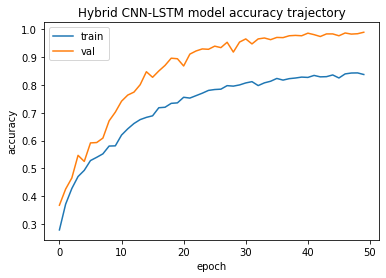

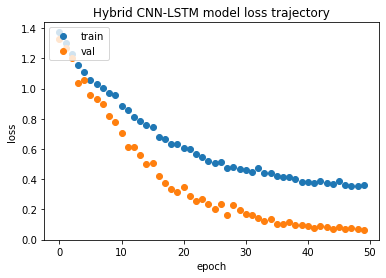

In [152]:
import matplotlib.pyplot as plt

# Plotting accuracy trajectory
plt.plot(hybrid_cnn_lstm_model_results.history['acc'])
plt.plot(hybrid_cnn_lstm_model_results.history['val_acc'])
plt.title('Hybrid CNN-LSTM model accuracy trajectory')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plotting loss trajectory
plt.plot(hybrid_cnn_lstm_model_results.history['loss'],'o')
plt.plot(hybrid_cnn_lstm_model_results.history['val_loss'],'o')
plt.title('Hybrid CNN-LSTM model loss trajectory')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [153]:
## Testing the hybrid CNN-LSTM model

hybrid_cnn_lstm_score = hybrid_cnn_lstm_model.evaluate(x_test, y_test, verbose=0)
print('Test accuracy of the hybrid CNN-LSTM model:',hybrid_cnn_lstm_score[1])

Test accuracy of the hybrid CNN-LSTM model: 0.6839729


# Function of Time - Optimized CNN (with preprocessing)

In [138]:
def cnn_model(time_period=1000):   
    time_period = min(time_period, 250)
    
    # Building the CNN model using sequential class
    basic_cnn_model = Sequential()
    
    # Conv. block 1
    basic_cnn_model.add(Conv2D(filters=100, kernel_size=(10,1), padding='same', activation='elu', input_shape=(time_period,1,22)))
    basic_cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same')) # Read the keras documentation
    basic_cnn_model.add(BatchNormalization())
    basic_cnn_model.add(Dropout(0.5))

    # Conv. block 2
    basic_cnn_model.add(Conv2D(filters=100, kernel_size=(10,1), padding='same', activation='elu'))
    basic_cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
    basic_cnn_model.add(BatchNormalization())
    basic_cnn_model.add(Dropout(0.5))

    # Conv. block 3
    basic_cnn_model.add(Conv2D(filters=100, kernel_size=(10,1), padding='same', activation='elu'))
    basic_cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
    basic_cnn_model.add(BatchNormalization())
    basic_cnn_model.add(Dropout(0.5))

    # Conv. block 4
    basic_cnn_model.add(Conv2D(filters=100, kernel_size=(10,1), padding='same', activation='elu'))
    basic_cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
    basic_cnn_model.add(BatchNormalization())
    basic_cnn_model.add(Dropout(0.5))

    # Output layer with Softmax activation
    basic_cnn_model.add(Flatten()) # Flattens the input
    basic_cnn_model.add(Dense(4, activation='softmax')) # Output FC layer with softmax activation
    
    cnn_optimizer = optimizers.Adam(learning_rate)
    
    basic_cnn_model.compile(loss='categorical_crossentropy',
                     optimizer=cnn_optimizer,
                     metrics=['accuracy'])

    # Printing the model summary
    basic_cnn_model.summary()
    
    return basic_cnn_model

In [139]:
# Model parameters
learning_rate = 1.5e-3
epochs = 50

In [140]:
def train_data(time_period=1000):
    # different period of time
    x_train_time = x_train[:,:time_period,:,:]
    y_train_time = y_train
    x_valid_time = x_valid[:,:time_period,:,:]
    y_valid_time = y_valid
    x_test_time = x_test[:,:time_period,:,:]
    y_test_time = y_test
    
    
    model = cnn_model(time_period)

    # Training and validating the model
    cnn_model_results = model.fit(x_train_time,
                 y_train_time,
                 batch_size=200,
                 epochs=epochs,
                 validation_data=(x_valid_time, y_valid_time), verbose=True)
    
    train_score = model.evaluate(x_train_time, y_train_time)
    
    test_score = model.evaluate(x_test_time, y_test_time)

    print('train {:s}: {:.3f}%'.format(model.metrics_names[1], train_score[1]*100))
    print('test {:s}: {:.3f}%'.format(model.metrics_names[1], test_score[1]*100))
    #print(model.summary())
    
    return train_score, test_score

In [141]:
train_scores = []
test_scores = []

for time in range(25, 251, 25):
    print("=================" + str(time) + "===================")
    train_score, test_score = train_data(time_period=time)
    train_scores.append(train_score[1])
    test_scores.append(test_score[1])

=================25===================
Model: "sequential_64"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_252 (Conv2D)          (None, 25, 1, 100)        22100     
_________________________________________________________________
max_pooling2d_252 (MaxPoolin (None, 9, 1, 100)         0         
_________________________________________________________________
batch_normalization_252 (Bat (None, 9, 1, 100)         400       
_________________________________________________________________
dropout_252 (Dropout)        (None, 9, 1, 100)         0         
_________________________________________________________________
conv2d_253 (Conv2D)          (None, 9, 1, 100)         100100    
_________________________________________________________________
max_pooling2d_253 (MaxPoolin (None, 3, 1, 100)         0         
_________________________________________________________________
batch_normaliz

Epoch 40/50
6960/6960 [==============================] - 1s 149us/sample - loss: 0.8210 - acc: 0.6599 - val_loss: 0.6925 - val_acc: 0.7327
Epoch 41/50
6960/6960 [==============================] - 1s 131us/sample - loss: 0.8139 - acc: 0.6789 - val_loss: 0.6610 - val_acc: 0.7593
Epoch 42/50
6960/6960 [==============================] - 1s 124us/sample - loss: 0.8041 - acc: 0.6776 - val_loss: 0.6400 - val_acc: 0.7693
Epoch 43/50
6960/6960 [==============================] - 1s 127us/sample - loss: 0.7953 - acc: 0.6779 - val_loss: 0.6201 - val_acc: 0.7720
Epoch 44/50
6960/6960 [==============================] - 1s 133us/sample - loss: 0.7704 - acc: 0.6944 - val_loss: 0.6044 - val_acc: 0.7827
Epoch 45/50
6960/6960 [==============================] - 1s 134us/sample - loss: 0.7951 - acc: 0.6848 - val_loss: 0.6218 - val_acc: 0.7693
Epoch 46/50
6960/6960 [==============================] - 1s 130us/sample - loss: 0.7616 - acc: 0.6968 - val_loss: 0.5825 - val_acc: 0.7907
Epoch 47/50
6960/6960 [====

Epoch 27/50
6960/6960 [==============================] - 1s 133us/sample - loss: 0.8044 - acc: 0.6790 - val_loss: 0.6277 - val_acc: 0.7553
Epoch 28/50
6960/6960 [==============================] - 1s 133us/sample - loss: 0.7744 - acc: 0.6912 - val_loss: 0.5979 - val_acc: 0.7620
Epoch 29/50
6960/6960 [==============================] - 1s 133us/sample - loss: 0.7560 - acc: 0.7009 - val_loss: 0.5523 - val_acc: 0.8053
Epoch 30/50
6960/6960 [==============================] - 1s 133us/sample - loss: 0.7480 - acc: 0.7000 - val_loss: 0.5790 - val_acc: 0.7767
Epoch 31/50
6960/6960 [==============================] - 1s 138us/sample - loss: 0.7232 - acc: 0.7151 - val_loss: 0.5153 - val_acc: 0.8093
Epoch 32/50
6960/6960 [==============================] - 1s 137us/sample - loss: 0.7053 - acc: 0.7191 - val_loss: 0.4995 - val_acc: 0.8267
Epoch 33/50
6960/6960 [==============================] - 1s 134us/sample - loss: 0.6753 - acc: 0.7343 - val_loss: 0.4803 - val_acc: 0.8153
Epoch 34/50
6960/6960 [====

6960/6960 [==============================] - 10s 1ms/sample - loss: 1.9950 - acc: 0.2891 - val_loss: 2.1358 - val_acc: 0.3353
Epoch 2/50
6960/6960 [==============================] - 1s 168us/sample - loss: 1.6372 - acc: 0.3162 - val_loss: 1.6983 - val_acc: 0.3133
Epoch 3/50
6960/6960 [==============================] - 1s 166us/sample - loss: 1.4961 - acc: 0.3236 - val_loss: 1.4002 - val_acc: 0.3847
Epoch 4/50
6960/6960 [==============================] - 1s 157us/sample - loss: 1.3703 - acc: 0.3759 - val_loss: 1.1735 - val_acc: 0.4813
Epoch 5/50
6960/6960 [==============================] - 1s 166us/sample - loss: 1.2787 - acc: 0.4300 - val_loss: 1.0998 - val_acc: 0.5393
Epoch 6/50
6960/6960 [==============================] - 1s 163us/sample - loss: 1.2099 - acc: 0.4632 - val_loss: 1.0856 - val_acc: 0.5513
Epoch 7/50
6960/6960 [==============================] - 1s 163us/sample - loss: 1.1685 - acc: 0.4816 - val_loss: 1.1029 - val_acc: 0.5253
Epoch 8/50
6960/6960 [========================

Epoch 1/50
6960/6960 [==============================] - 10s 1ms/sample - loss: 2.0110 - acc: 0.2918 - val_loss: 5.2624 - val_acc: 0.2527
Epoch 2/50
6960/6960 [==============================] - 1s 181us/sample - loss: 1.6468 - acc: 0.3207 - val_loss: 1.6907 - val_acc: 0.3367
Epoch 3/50
6960/6960 [==============================] - 1s 179us/sample - loss: 1.4583 - acc: 0.3717 - val_loss: 1.1928 - val_acc: 0.4593
Epoch 4/50
6960/6960 [==============================] - 1s 183us/sample - loss: 1.3177 - acc: 0.4180 - val_loss: 1.1016 - val_acc: 0.5127
Epoch 5/50
6960/6960 [==============================] - 1s 182us/sample - loss: 1.2019 - acc: 0.4718 - val_loss: 1.0377 - val_acc: 0.5540
Epoch 6/50
6960/6960 [==============================] - 1s 177us/sample - loss: 1.1394 - acc: 0.5063 - val_loss: 0.9585 - val_acc: 0.6047
Epoch 7/50
6960/6960 [==============================] - 1s 185us/sample - loss: 1.0907 - acc: 0.5366 - val_loss: 0.9332 - val_acc: 0.6200
Epoch 8/50
6960/6960 [=============

Epoch 1/50
6960/6960 [==============================] - 9s 1ms/sample - loss: 2.0574 - acc: 0.2838 - val_loss: 3.3743 - val_acc: 0.3273
Epoch 2/50
6960/6960 [==============================] - 1s 203us/sample - loss: 1.6581 - acc: 0.3158 - val_loss: 2.0264 - val_acc: 0.3293
Epoch 3/50
6960/6960 [==============================] - 1s 200us/sample - loss: 1.4621 - acc: 0.3665 - val_loss: 1.2464 - val_acc: 0.4720
Epoch 4/50
6960/6960 [==============================] - 1s 204us/sample - loss: 1.2876 - acc: 0.4325 - val_loss: 1.0936 - val_acc: 0.5333
Epoch 5/50
6960/6960 [==============================] - 1s 199us/sample - loss: 1.2178 - acc: 0.4721 - val_loss: 1.0276 - val_acc: 0.5647
Epoch 6/50
6960/6960 [==============================] - 1s 206us/sample - loss: 1.1238 - acc: 0.5122 - val_loss: 0.9712 - val_acc: 0.5967
Epoch 7/50
6960/6960 [==============================] - 1s 202us/sample - loss: 1.0698 - acc: 0.5455 - val_loss: 0.9307 - val_acc: 0.6307
Epoch 8/50
6960/6960 [==============

Epoch 1/50
6960/6960 [==============================] - 10s 1ms/sample - loss: 1.9882 - acc: 0.2953 - val_loss: 2.5464 - val_acc: 0.3180
Epoch 2/50
6960/6960 [==============================] - 2s 223us/sample - loss: 1.5814 - acc: 0.3408 - val_loss: 1.8870 - val_acc: 0.3773
Epoch 3/50
6960/6960 [==============================] - 2s 227us/sample - loss: 1.4207 - acc: 0.3818 - val_loss: 1.1831 - val_acc: 0.4753
Epoch 4/50
6960/6960 [==============================] - 2s 224us/sample - loss: 1.2787 - acc: 0.4420 - val_loss: 1.0193 - val_acc: 0.5840
Epoch 5/50
6960/6960 [==============================] - 2s 226us/sample - loss: 1.1583 - acc: 0.5000 - val_loss: 1.0259 - val_acc: 0.5840
Epoch 6/50
6960/6960 [==============================] - 2s 218us/sample - loss: 1.0928 - acc: 0.5391 - val_loss: 0.9142 - val_acc: 0.6220
Epoch 7/50
6960/6960 [==============================] - 2s 221us/sample - loss: 1.0268 - acc: 0.5731 - val_loss: 0.8389 - val_acc: 0.6900
Epoch 8/50
6960/6960 [=============

Epoch 1/50
6960/6960 [==============================] - 11s 2ms/sample - loss: 1.9357 - acc: 0.3116 - val_loss: 4.0915 - val_acc: 0.3680
Epoch 2/50
6960/6960 [==============================] - 2s 253us/sample - loss: 1.5985 - acc: 0.3435 - val_loss: 2.1639 - val_acc: 0.3900
Epoch 3/50
6960/6960 [==============================] - 2s 244us/sample - loss: 1.3728 - acc: 0.4039 - val_loss: 1.2113 - val_acc: 0.5120
Epoch 4/50
6960/6960 [==============================] - 2s 243us/sample - loss: 1.2301 - acc: 0.4688 - val_loss: 1.0794 - val_acc: 0.5460
Epoch 5/50
6960/6960 [==============================] - 2s 240us/sample - loss: 1.1478 - acc: 0.5083 - val_loss: 0.9750 - val_acc: 0.6040
Epoch 6/50
6960/6960 [==============================] - 2s 259us/sample - loss: 1.0765 - acc: 0.5468 - val_loss: 0.9486 - val_acc: 0.6107
Epoch 7/50
6960/6960 [==============================] - 2s 252us/sample - loss: 1.0051 - acc: 0.5816 - val_loss: 0.8316 - val_acc: 0.6720
Epoch 8/50
6960/6960 [=============

Epoch 1/50
6960/6960 [==============================] - 11s 2ms/sample - loss: 1.9915 - acc: 0.3126 - val_loss: 3.4654 - val_acc: 0.3353
Epoch 2/50
6960/6960 [==============================] - 2s 274us/sample - loss: 1.5734 - acc: 0.3506 - val_loss: 1.6883 - val_acc: 0.3927
Epoch 3/50
6960/6960 [==============================] - 2s 265us/sample - loss: 1.3647 - acc: 0.4164 - val_loss: 1.1924 - val_acc: 0.5227
Epoch 4/50
6960/6960 [==============================] - 2s 264us/sample - loss: 1.2191 - acc: 0.4830 - val_loss: 1.1014 - val_acc: 0.5440
Epoch 5/50
6960/6960 [==============================] - 2s 274us/sample - loss: 1.1164 - acc: 0.5259 - val_loss: 0.9982 - val_acc: 0.5873
Epoch 6/50
6960/6960 [==============================] - 2s 280us/sample - loss: 1.0485 - acc: 0.5624 - val_loss: 0.8875 - val_acc: 0.6473
Epoch 7/50
6960/6960 [==============================] - 2s 280us/sample - loss: 0.9895 - acc: 0.5875 - val_loss: 0.8424 - val_acc: 0.6673
Epoch 8/50
6960/6960 [=============

Epoch 1/50
6960/6960 [==============================] - 11s 2ms/sample - loss: 1.9250 - acc: 0.3109 - val_loss: 3.9406 - val_acc: 0.3653
Epoch 2/50
6960/6960 [==============================] - 2s 292us/sample - loss: 1.5309 - acc: 0.3615 - val_loss: 1.8074 - val_acc: 0.4300
Epoch 3/50
6960/6960 [==============================] - 2s 297us/sample - loss: 1.3296 - acc: 0.4346 - val_loss: 1.1558 - val_acc: 0.5353
Epoch 4/50
6960/6960 [==============================] - 2s 301us/sample - loss: 1.2034 - acc: 0.4846 - val_loss: 1.0337 - val_acc: 0.5867
Epoch 5/50
6960/6960 [==============================] - 2s 296us/sample - loss: 1.1070 - acc: 0.5361 - val_loss: 0.9013 - val_acc: 0.6547
Epoch 6/50
6960/6960 [==============================] - 2s 308us/sample - loss: 1.0307 - acc: 0.5638 - val_loss: 0.8719 - val_acc: 0.6547
Epoch 7/50
6960/6960 [==============================] - 2s 288us/sample - loss: 0.9618 - acc: 0.6017 - val_loss: 0.8002 - val_acc: 0.6993
Epoch 8/50
6960/6960 [=============

Train accuracies: 
[0.92298853, 0.9836207, 0.99094826, 0.9946839, 0.99971265, 0.99956894, 0.9987069, 0.9982759, 0.9992816, 0.99956894]
Test accuracies: 
[0.38826185, 0.5248307, 0.59424376, 0.6444695, 0.6743792, 0.69808125, 0.6918736, 0.7020316, 0.69977427, 0.72460496]


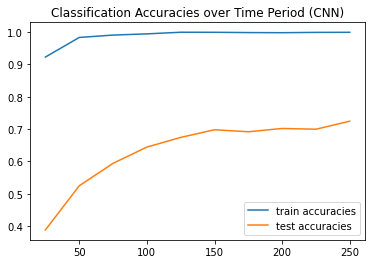

In [142]:
print("Train accuracies: ")
print(train_scores)
print("Test accuracies: ")
print(test_scores)

# plot
plt.plot(range(25, 251, 25), train_scores, label='train accuracies')
plt.plot(range(25, 251, 25), test_scores, label='test accuracies')
plt.legend()
plt.title("Classification Accuracies over Time Period (CNN)")
plt.show()

# Function of Time - Optimized CNN+LSTM (with preprocessing)

In [158]:
def hybrid_model(time_period=250):   
    
    # Building the CNN model using sequential class
    hybrid_cnn_lstm_model = Sequential()

    # Conv. block 1
    hybrid_cnn_lstm_model.add(Conv2D(filters=100, kernel_size=(10,1), padding='same', activation='elu', input_shape=(time_period,1,22)))
    hybrid_cnn_lstm_model.add(MaxPooling2D(pool_size=(3,1), padding='same')) # Read the keras documentation
    hybrid_cnn_lstm_model.add(BatchNormalization())
    hybrid_cnn_lstm_model.add(Dropout(0.5))

    # Conv. block 2
    hybrid_cnn_lstm_model.add(Conv2D(filters=100, kernel_size=(10,1), padding='same', activation='elu'))
    hybrid_cnn_lstm_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
    hybrid_cnn_lstm_model.add(BatchNormalization())
    hybrid_cnn_lstm_model.add(Dropout(0.5))

    # Conv. block 3
    hybrid_cnn_lstm_model.add(Conv2D(filters=100, kernel_size=(10,1), padding='same', activation='elu'))
    hybrid_cnn_lstm_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
    hybrid_cnn_lstm_model.add(BatchNormalization())
    hybrid_cnn_lstm_model.add(Dropout(0.5))

    # Conv. block 4
    #hybrid_cnn_lstm_model.add(Conv2D(filters=100, kernel_size=(10,1), padding='same', activation='elu'))
    #hybrid_cnn_lstm_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
    #hybrid_cnn_lstm_model.add(BatchNormalization())
    #hybrid_cnn_lstm_model.add(Dropout(0.5))

    # FC+LSTM layers
    hybrid_cnn_lstm_model.add(Flatten()) # Adding a flattening operation to the output of CNN block
    hybrid_cnn_lstm_model.add(Dense((100))) # FC layer with 100 units
    hybrid_cnn_lstm_model.add(Reshape((100,1))) # Reshape my output of FC layer so that it's compatible
    hybrid_cnn_lstm_model.add(LSTM(100, dropout=0.5, recurrent_dropout=0.1, input_shape=(100,1), return_sequences=True))

    hybrid_cnn_lstm_model.add(LSTM(70, dropout=0.5, recurrent_dropout=0.1, return_sequences=False))
    # Output layer with Softmax activation 
    hybrid_cnn_lstm_model.add(Dense(4, activation='softmax')) # Output FC layer with softmax activation


    hybrid_cnn_lstm_model.compile(loss='categorical_crossentropy', optimizer=hybrid_cnn_lstm_optimizer, metrics=['accuracy'])

    # Printing the model summary
    hybrid_cnn_lstm_model.summary()
    
    return hybrid_cnn_lstm_model

In [159]:
# Model parameters
learning_rate = 2e-3
epochs = 50
hybrid_cnn_lstm_optimizer = optimizers.Adam(lr=learning_rate)

In [160]:
def hybrid_train_data(time_period=250):
    # different period of time
    x_train_time = x_train[:,:time_period,:,:]
    y_train_time = y_train
    x_valid_time = x_valid[:,:time_period,:,:]
    y_valid_time = y_valid
    x_test_time = x_test[:,:time_period,:,:]
    y_test_time = y_test
    
    
    model = hybrid_model(time_period)

    # Training and validating the model
    cnn_model_results = model.fit(x_train_time,
                 y_train_time,
                 batch_size=200,
                 epochs=epochs,
                 validation_data=(x_valid_time, y_valid_time), verbose=True)
    
    train_score = model.evaluate(x_train_time, y_train_time)
    
    test_score = model.evaluate(x_test_time, y_test_time)

    print('train {:s}: {:.3f}%'.format(model.metrics_names[1], train_score[1]*100))
    print('test {:s}: {:.3f}%'.format(model.metrics_names[1], test_score[1]*100))
    #print(model.summary())
    
    return train_score, test_score

In [161]:
train_scores = []
test_scores = []

for time in range(25, 251, 25):
    print("=================" + str(time) + "===================")
    train_score, test_score = hybrid_train_data(time_period=time)
    train_scores.append(train_score[1])
    test_scores.append(test_score[1])

=================25===================
Model: "sequential_77"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_301 (Conv2D)          (None, 25, 1, 100)        22100     
_________________________________________________________________
max_pooling2d_301 (MaxPoolin (None, 9, 1, 100)         0         
_________________________________________________________________
batch_normalization_301 (Bat (None, 9, 1, 100)         400       
_________________________________________________________________
dropout_301 (Dropout)        (None, 9, 1, 100)         0         
_________________________________________________________________
conv2d_302 (Conv2D)          (None, 9, 1, 100)         100100    
_________________________________________________________________
max_pooling2d_302 (MaxPoolin (None, 3, 1, 100)         0         
_________________________________________________________________
batch_normaliz

Epoch 40/50
6960/6960 [==============================] - 20s 3ms/sample - loss: 0.8508 - acc: 0.6476 - val_loss: 0.7429 - val_acc: 0.7393
Epoch 41/50
6960/6960 [==============================] - 25s 4ms/sample - loss: 0.8259 - acc: 0.6632 - val_loss: 0.7200 - val_acc: 0.7373
Epoch 42/50
6960/6960 [==============================] - 26s 4ms/sample - loss: 0.8331 - acc: 0.6552 - val_loss: 0.7211 - val_acc: 0.7473
Epoch 43/50
6960/6960 [==============================] - 23s 3ms/sample - loss: 0.8126 - acc: 0.6648 - val_loss: 0.6939 - val_acc: 0.7487
Epoch 44/50
6960/6960 [==============================] - 23s 3ms/sample - loss: 0.8131 - acc: 0.6654 - val_loss: 0.6690 - val_acc: 0.7607
Epoch 45/50
6960/6960 [==============================] - 22s 3ms/sample - loss: 0.7999 - acc: 0.6697 - val_loss: 0.6787 - val_acc: 0.7653
Epoch 46/50
6960/6960 [==============================] - 21s 3ms/sample - loss: 0.7901 - acc: 0.6737 - val_loss: 0.6778 - val_acc: 0.7507
Epoch 47/50
6960/6960 [===========

6960/6960 [==============================] - 22s 3ms/sample - loss: 0.9701 - acc: 0.5957 - val_loss: 0.7696 - val_acc: 0.7173
Epoch 15/50
6960/6960 [==============================] - 23s 3ms/sample - loss: 0.9416 - acc: 0.6135 - val_loss: 0.7941 - val_acc: 0.6827
Epoch 16/50
6960/6960 [==============================] - 23s 3ms/sample - loss: 0.8993 - acc: 0.6272 - val_loss: 0.7412 - val_acc: 0.7287
Epoch 17/50
6960/6960 [==============================] - 23s 3ms/sample - loss: 0.8735 - acc: 0.6455 - val_loss: 0.6772 - val_acc: 0.7640
Epoch 18/50
6960/6960 [==============================] - 22s 3ms/sample - loss: 0.8464 - acc: 0.6497 - val_loss: 0.7482 - val_acc: 0.7187
Epoch 19/50
6960/6960 [==============================] - 22s 3ms/sample - loss: 0.8483 - acc: 0.6526 - val_loss: 0.6755 - val_acc: 0.7627
Epoch 20/50
6960/6960 [==============================] - 22s 3ms/sample - loss: 0.8073 - acc: 0.6654 - val_loss: 0.6168 - val_acc: 0.7813
Epoch 21/50
6960/6960 [=======================

Epoch 1/50
6960/6960 [==============================] - 34s 5ms/sample - loss: 1.3935 - acc: 0.2635 - val_loss: 1.3758 - val_acc: 0.3027
Epoch 2/50
6960/6960 [==============================] - 20s 3ms/sample - loss: 1.3637 - acc: 0.3073 - val_loss: 1.3742 - val_acc: 0.3247
Epoch 3/50
6960/6960 [==============================] - 22s 3ms/sample - loss: 1.3429 - acc: 0.3338 - val_loss: 1.2850 - val_acc: 0.3927
Epoch 4/50
6960/6960 [==============================] - 22s 3ms/sample - loss: 1.3096 - acc: 0.3723 - val_loss: 1.3102 - val_acc: 0.3873
Epoch 5/50
6960/6960 [==============================] - 20s 3ms/sample - loss: 1.2481 - acc: 0.4307 - val_loss: 1.3214 - val_acc: 0.4193
Epoch 6/50
6960/6960 [==============================] - 21s 3ms/sample - loss: 1.2032 - acc: 0.4596 - val_loss: 1.0932 - val_acc: 0.5220
Epoch 7/50
6960/6960 [==============================] - 23s 3ms/sample - loss: 1.1640 - acc: 0.4796 - val_loss: 1.1006 - val_acc: 0.5187
Epoch 8/50
6960/6960 [===================

Epoch 1/50
6960/6960 [==============================] - 34s 5ms/sample - loss: 1.3909 - acc: 0.2654 - val_loss: 1.4594 - val_acc: 0.2487
Epoch 2/50
6960/6960 [==============================] - 19s 3ms/sample - loss: 1.3682 - acc: 0.2977 - val_loss: 1.4180 - val_acc: 0.2647
Epoch 3/50
6960/6960 [==============================] - 19s 3ms/sample - loss: 1.3406 - acc: 0.3361 - val_loss: 1.3352 - val_acc: 0.3460
Epoch 4/50
6960/6960 [==============================] - 19s 3ms/sample - loss: 1.2857 - acc: 0.4036 - val_loss: 1.2621 - val_acc: 0.4153
Epoch 5/50
6960/6960 [==============================] - 19s 3ms/sample - loss: 1.2220 - acc: 0.4448 - val_loss: 1.1425 - val_acc: 0.4853
Epoch 6/50
6960/6960 [==============================] - 20s 3ms/sample - loss: 1.1498 - acc: 0.4866 - val_loss: 1.1251 - val_acc: 0.5167
Epoch 7/50
6960/6960 [==============================] - 20s 3ms/sample - loss: 1.1074 - acc: 0.5162 - val_loss: 1.0506 - val_acc: 0.5560
Epoch 8/50
6960/6960 [===================

Epoch 1/50
6960/6960 [==============================] - 33s 5ms/sample - loss: 1.3799 - acc: 0.2958 - val_loss: 1.4490 - val_acc: 0.3233
Epoch 2/50
6960/6960 [==============================] - 18s 3ms/sample - loss: 1.3218 - acc: 0.3639 - val_loss: 1.3001 - val_acc: 0.3847
Epoch 3/50
6960/6960 [==============================] - 18s 3ms/sample - loss: 1.2684 - acc: 0.3990 - val_loss: 1.1946 - val_acc: 0.4607
Epoch 4/50
6960/6960 [==============================] - 18s 3ms/sample - loss: 1.1949 - acc: 0.4494 - val_loss: 1.1772 - val_acc: 0.4653
Epoch 5/50
6960/6960 [==============================] - 19s 3ms/sample - loss: 1.1387 - acc: 0.4839 - val_loss: 1.0595 - val_acc: 0.5193
Epoch 6/50
6960/6960 [==============================] - 20s 3ms/sample - loss: 1.1063 - acc: 0.5036 - val_loss: 0.9890 - val_acc: 0.5673
Epoch 7/50
6960/6960 [==============================] - 19s 3ms/sample - loss: 1.0480 - acc: 0.5369 - val_loss: 0.9666 - val_acc: 0.5860
Epoch 8/50
6960/6960 [===================

Epoch 1/50
6960/6960 [==============================] - 74s 11ms/sample - loss: 1.3708 - acc: 0.3030 - val_loss: 1.3778 - val_acc: 0.2800
Epoch 2/50
6960/6960 [==============================] - 45s 6ms/sample - loss: 1.2766 - acc: 0.3971 - val_loss: 1.2920 - val_acc: 0.3820
Epoch 3/50
6960/6960 [==============================] - 41s 6ms/sample - loss: 1.2035 - acc: 0.4432 - val_loss: 1.2206 - val_acc: 0.4367
Epoch 4/50
6960/6960 [==============================] - 40s 6ms/sample - loss: 1.1359 - acc: 0.4907 - val_loss: 1.1492 - val_acc: 0.4720
Epoch 5/50
6960/6960 [==============================] - 34s 5ms/sample - loss: 1.0736 - acc: 0.5164 - val_loss: 1.0206 - val_acc: 0.5580
Epoch 6/50
6960/6960 [==============================] - 38s 6ms/sample - loss: 1.0294 - acc: 0.5407 - val_loss: 0.9279 - val_acc: 0.5980
Epoch 7/50
6960/6960 [==============================] - 48s 7ms/sample - loss: 0.9850 - acc: 0.5662 - val_loss: 0.9467 - val_acc: 0.5693
Epoch 8/50
6960/6960 [==================

Epoch 1/50
6960/6960 [==============================] - 49s 7ms/sample - loss: 1.3816 - acc: 0.2961 - val_loss: 1.7049 - val_acc: 0.2587
Epoch 2/50
6960/6960 [==============================] - 25s 4ms/sample - loss: 1.3027 - acc: 0.3664 - val_loss: 1.2595 - val_acc: 0.3940
Epoch 3/50
6960/6960 [==============================] - 24s 3ms/sample - loss: 1.2255 - acc: 0.4378 - val_loss: 1.1519 - val_acc: 0.4827
Epoch 4/50
6960/6960 [==============================] - 23s 3ms/sample - loss: 1.1651 - acc: 0.4662 - val_loss: 1.1111 - val_acc: 0.5000
Epoch 5/50
6960/6960 [==============================] - 23s 3ms/sample - loss: 1.1366 - acc: 0.4829 - val_loss: 1.0353 - val_acc: 0.5373
Epoch 6/50
6960/6960 [==============================] - 24s 3ms/sample - loss: 1.2978 - acc: 0.3828 - val_loss: 1.1873 - val_acc: 0.4607
Epoch 7/50
6960/6960 [==============================] - 24s 3ms/sample - loss: 1.2076 - acc: 0.4484 - val_loss: 1.0832 - val_acc: 0.5087
Epoch 8/50
6960/6960 [===================

Epoch 1/50
6960/6960 [==============================] - 41s 6ms/sample - loss: 1.3886 - acc: 0.2851 - val_loss: 1.5272 - val_acc: 0.2653
Epoch 2/50
6960/6960 [==============================] - 23s 3ms/sample - loss: 1.3034 - acc: 0.3786 - val_loss: 1.2530 - val_acc: 0.4120
Epoch 3/50
6960/6960 [==============================] - 22s 3ms/sample - loss: 1.2079 - acc: 0.4422 - val_loss: 1.2539 - val_acc: 0.4553
Epoch 4/50
6960/6960 [==============================] - 23s 3ms/sample - loss: 1.1450 - acc: 0.4739 - val_loss: 1.0799 - val_acc: 0.5213
Epoch 5/50
6960/6960 [==============================] - 23s 3ms/sample - loss: 1.0883 - acc: 0.5057 - val_loss: 1.0616 - val_acc: 0.5447
Epoch 6/50
6960/6960 [==============================] - 24s 3ms/sample - loss: 1.0414 - acc: 0.5323 - val_loss: 0.9346 - val_acc: 0.6047
Epoch 7/50
6960/6960 [==============================] - 21s 3ms/sample - loss: 0.9894 - acc: 0.5583 - val_loss: 0.8898 - val_acc: 0.6273
Epoch 8/50
6960/6960 [===================

Train accuracies: 
[0.9166667, 0.9817529, 0.9883621, 0.9935345, 0.9928161, 0.9945402, 0.99425286, 0.9982759, 0.97341955, 0.9992816]
Test accuracies: 
[0.38431153, 0.5, 0.5733634, 0.5993228, 0.6106095, 0.65462756, 0.62471783, 0.6670429, 0.64503384, 0.64503384]


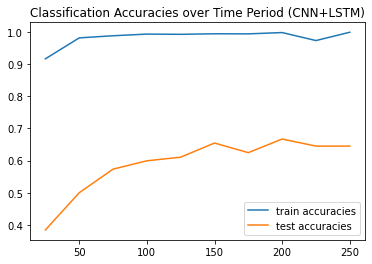

In [163]:
print("Train accuracies: ")
print(train_scores)
print("Test accuracies: ")
print(test_scores)

# plot
plt.plot(range(25, 251, 25), train_scores, label='train accuracies')
plt.plot(range(25, 251, 25), test_scores, label='test accuracies')
plt.legend()
plt.title("Classification Accuracies over Time Period (CNN+LSTM)")
plt.show()